Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [86]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib
%matplotlib inline

In [87]:
def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["BK"] >= -999]
    feature = feature[feature["SP"] >= -999]
    return feature

In [135]:


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    return feature

def get_for_learn_clean_df_spk400(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 > 0.001]
    feature = feature[feature["MD"] > 1850]
    feature['wellName'] = 'spk400_shift'
    return feature

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def get_for_learn_clean_df_spk427R(for_ml):
    def get_merge_df(one, two):
        one_copy =  one.copy()
        tho_copy = two.copy()
        new_df = pd.merge(one_copy, tho_copy,  how='inner', left_on=['wellName','MD'], right_on = ['wellName','MD'])
        return new_df

    for_ml_clone = for_ml.copy()
    for_ml_clone = for_ml_clone[for_ml_clone['wellName'] == 'spk427R']
    del for_ml_clone['BK']
    del for_ml_clone['SP']
    del for_ml_clone['NKTB']
    del for_ml_clone['LIT']
    del for_ml_clone['GR']
    del for_ml_clone['LAYER']

    spk427R = pd.read_csv('spk427R_TrainLogs.csv', sep=';')
    well = get_merge_df(for_ml_clone, spk427R)
    display(well.describe())
    del well['AGR']
    del well['ASP']
    del well['datasetName']
    return well

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

for_ml = get_for_learn_clean_df(pd.read_csv('DATATRAIN18+LAYER.csv', sep=';'))
spk427R = get_for_learn_clean_df_spk427R(for_ml)
spk400 = get_for_learn_clean_df_spk400(pd.read_csv('DATATRAIN18+LAYER.csv', sep=';'))
for_ml = for_ml[for_ml['wellName'] != 'spk427R']
for_ml = pd.concat([for_ml, spk400, spk427R])
display(for_ml.describe())
display(for_ml)
wells_samples_df = get_well_dfs(for_ml)

MD       Facies         AGR         ASP          BK  \
count   310.000000   310.000000  310.000000  310.000000  310.000000   
mean   2586.900000 -2415.990323    0.443719    0.091886    9.137045   
std      17.926703  4290.816865    0.260089    0.094558    7.720558   
min    2556.000000 -9999.000000    0.000000    0.000000    5.345500   
25%    2571.450000     0.000000    0.214541    0.011352    7.181000   
50%    2586.900000     5.000000    0.417163    0.052764    7.973250   
75%    2602.350000     5.000000    0.643623    0.178180    8.979625   
max    2617.800000     8.000000    1.000000    0.317823  129.264500   

               GR         LIT        NKTB          SP  
count  310.000000  310.000000  310.000000  310.000000  
mean    10.891935    2.051613    3.933336  113.830968  
std      3.222438    1.422398    0.650787    4.948310  
min      5.300000    1.000000    3.033252  103.900000  
25%      9.000000    1.000000    3.550536  110.600000  
50%     10.900000    1.000000    3.795809  113.200000  
75%     12.600000    4.000000    4.129428  118.400000  
max     37.100000    5.000000    8.385099  123.600000

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



BK        Facies            GR           LIT            MD  \
count  65951.000000  69839.000000  69839.000000  69839.000000  69839.000000   
mean   -1579.525331  -9517.122396   -277.581893  -7693.602557   2297.936202   
std     3674.660162   2142.106428   1675.647925   4212.096414    265.521343   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000   1850.100000   
25%        4.383000  -9999.000000      7.949000  -9999.000000   2078.400000   
50%        6.770000  -9999.000000     10.080000  -9999.000000   2292.200000   
75%        9.380000  -9999.000000     12.600000  -9999.000000   2497.600000   
max    22739.520000     12.000000    142.370000      6.000000   3093.000000   

               NKTB            SP  
count  69839.000000  69839.000000  
mean    -275.478164      2.011366  
std     1647.951269   1028.578321  
min    -9999.000000  -9999.000000  
25%        3.250043     82.895565  
50%        3.750000    106.186100  
75%        4.200779    123.124450  
max       15.351170    578.255500

BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName
0    4.420000   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521
1    4.300000   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521
2    4.310000   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521
3    4.280000   -9999  13.03  -9999 -9999  2011.6  2.989185   97.86  spk1521
4    4.260000   -9999  12.94  -9999 -9999  2011.8  2.968678   98.15  spk1521
..        ...     ...    ...    ...   ...     ...       ...     ...      ...
305  8.691000   -9999  12.60     U1     1  2617.0  3.698164  109.90  spk427R
306  8.563000   -9999  12.90     U1     1  2617.2  3.535424  110.70  spk427R
307  8.091500   -9999  13.70     U1     1  2617.4  3.577271  110.80  spk427R
308  8.374000   -9999  13.30     U1     1  2617.6  3.772560  110.60  spk427R
309  8.577499   -9999  13.50     U1     1  2617.8  3.647017  110.90  spk427R

[69839 rows x 9 columns]

['spk1521' 'spk1527' 'spk1769' 'spk400' 'spk402' 'spk403' 'spk405R'
 'spk406R' 'spk409R' 'spk420R' 'spk424R' 'spk426R' 'spk428R' 'spk429L'
 'spk432R' 'spk967' 'spk400_shift' 'spk427R']


In [142]:
for_ml[for_ml['LIT'] != -9999]

BK  Facies     GR LAYER  LIT      MD      NKTB      SP wellName
5030  32.310000   -9999  46.83  Bazh    1  3017.0  3.251999  124.81  spk1521
5031   9.130000   -9999  43.03  Bazh    1  3017.2  3.328372  123.41  spk1521
5032   4.210000   -9999  34.81  Bazh    1  3017.4  3.422103  122.08  spk1521
5033   2.190000   -9999  24.77  Bazh    1  3017.6  3.581842  121.67  spk1521
5034   2.480000   -9999  17.87  Bazh    1  3017.8  3.736615  119.92  spk1521
...         ...     ...    ...   ...  ...     ...       ...     ...      ...
305    8.691000   -9999  12.60    U1    1  2617.0  3.698164  109.90  spk427R
306    8.563000   -9999  12.90    U1    1  2617.2  3.535424  110.70  spk427R
307    8.091500   -9999  13.70    U1    1  2617.4  3.577271  110.80  spk427R
308    8.374000   -9999  13.30    U1    1  2617.6  3.772560  110.60  spk427R
309    8.577499   -9999  13.50    U1    1  2617.8  3.647017  110.90  spk427R

[16099 rows x 9 columns]

['spk1521' 'spk1527' 'spk400' 'spk424R' 'spk428R' 'spk429L' 'spk432R'
 'spk400_shift']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BK  Facies          GR         LIT           MD        NKTB  \
count  108.000000   108.0  108.000000  108.000000   108.000000  108.000000   
mean    11.468056     7.0    8.842130    4.157407  3039.700000    5.254800   
std      7.497654     0.0    1.129343    0.725530     6.264184    0.442119   
min      4.020000     7.0    6.740000    1.000000  3029.000000    4.195716   
25%      5.982500     7.0    7.930000    4.000000  3034.350000    5.006951   
50%      9.435000     7.0    8.760000    4.000000  3039.700000    5.271079   
75%     13.785000     7.0    9.755000    5.000000  3045.050000    5.513675   
max     45.320000     7.0   11.990000    5.000000  3050.400000    6.191994   

               SP  shift_up  is_middle  
count  108.000000     108.0      108.0  
mean   100.723704       7.0       49.0  
std      4.398595       0.0        0.0  
min     95.560000       7.0       49.0  
25%     97.717500       7.0       49.0  
50%     99.475000       7.0       49.0  
75%    102.207500       7.0       49.0  
max    119.150000       7.0       49.0

        BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName
0     4.42   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521
1     4.30   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521
2     4.31   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521
3     4.28   -9999  13.03  -9999 -9999  2011.6  2.989185   97.86  spk1521
4     4.26   -9999  12.94  -9999 -9999  2011.8  2.968678   98.15  spk1521
...    ...     ...    ...    ...   ...     ...       ...     ...      ...
5406  7.85   -9999  18.86  UV1_3 -9999  3092.2  3.586331  131.68  spk1521
5407  7.84   -9999  18.64  UV1_3 -9999  3092.4  3.550309  132.38  spk1521
5408  7.85   -9999  18.49  UV1_3 -9999  3092.6  3.495778  132.12  spk1521
5409  7.84   -9999  18.49  UV1_3 -9999  3092.8  3.675269  131.83  spk1521
5410  7.84   -9999  18.49  UV1_3 -9999  3093.0  3.675269  131.83  spk1521

[5411 rows x 9 columns]


BK  Facies         GR        LIT           MD       NKTB  \
count  62.000000    62.0  62.000000  62.000000    62.000000  62.000000   
mean   17.811774     7.0   5.752258   3.419355  2693.300000   4.542258   
std     5.783489     0.0   0.825486   1.194913     3.608324   0.562044   
min     5.690000     7.0   5.080000   1.000000  2687.200000   3.440000   
25%    14.150000     7.0   5.322500   4.000000  2690.250000   4.195000   
50%    18.565000     7.0   5.545000   4.000000  2693.300000   4.400000   
75%    20.832500     7.0   5.687500   4.000000  2696.350000   4.807500   
max    32.980000     7.0   9.020000   4.000000  2699.400000   5.760000   

              SP  shift_up  is_middle  
count  62.000000      62.0       62.0  
mean   59.326290       7.0       49.0  
std     6.309395       0.0        0.0  
min    52.900000       7.0       49.0  
25%    56.620000       7.0       49.0  
50%    57.665000       7.0       49.0  
75%    58.745000       7.0       49.0  
max    81.730000       7.0       49.0

         BK  Facies       GR  LAYER   LIT      MD     NKTB     SP wellName
14662  3.07   -9999     7.89  -9999 -9999  1850.2     2.06  96.22  spk1527
14663  2.92   -9999     8.02  -9999 -9999  1850.4     2.05  95.43  spk1527
14664  2.87   -9999     8.06  -9999 -9999  1850.6     2.03  96.24  spk1527
14665  2.83   -9999     8.17  -9999 -9999  1850.8     2.07  97.14  spk1527
14666  3.19   -9999     8.25  -9999 -9999  1851.0     2.12  97.49  spk1527
...     ...     ...      ...    ...   ...     ...      ...    ...      ...
19260  7.56   -9999 -9999.00    UV2 -9999  2769.8 -9999.00  76.04  spk1527
19261  8.10   -9999 -9999.00    UV2 -9999  2770.0 -9999.00  77.77  spk1527
19262  8.20   -9999 -9999.00    UV2 -9999  2770.2 -9999.00  79.66  spk1527
19263  8.20   -9999 -9999.00    UV2 -9999  2770.4 -9999.00  83.38  spk1527
19264  8.20   -9999 -9999.00    UV2 -9999  2770.6 -9999.00  83.38  spk1527

[4603 rows x 9 columns]


BK  Facies         GR        LIT           MD       NKTB  \
count  44.000000    44.0  44.000000  44.000000    44.000000  44.000000   
mean   14.638182     7.0   6.369773   3.295455  2538.700000   4.539769   
std     3.378041     0.0   0.599308   1.001848     2.569047   0.227740   
min     7.880000     7.0   5.560000   1.000000  2534.400000   4.104653   
25%    11.492500     7.0   5.940000   2.000000  2536.550000   4.359206   
50%    15.505000     7.0   6.250000   4.000000  2538.700000   4.519977   
75%    17.237500     7.0   6.650000   4.000000  2540.850000   4.710892   
max    20.460000     7.0   8.830000   4.000000  2543.000000   5.029084   

               SP  shift_up  is_middle  
count   44.000000      44.0       44.0  
mean    98.821727       7.0       49.0  
std      8.349744       0.0        0.0  
min     87.790760       7.0       49.0  
25%     90.554348       7.0       49.0  
50%     98.845645       7.0       49.0  
75%    106.502300       7.0       49.0  
max    115.737500       7.0       49.0

         BK  Facies       GR  LAYER   LIT      MD      NKTB         SP  \
34747  7.05   -9999     8.85  -9999 -9999  1850.2  4.560170   105.8819   
34749  7.57   -9999     8.42  -9999 -9999  1850.4  4.801326   106.8136   
34751  7.62   -9999     8.00  -9999 -9999  1850.6  4.653953   109.3252   
34753  7.08   -9999     9.25  -9999 -9999  1850.8  4.426194   112.7668   
34755  6.18   -9999     9.48  -9999 -9999  1851.0  4.292219   115.9084   
...     ...     ...      ...    ...   ...     ...       ...        ...   
42057  5.59   -9999    10.06  UV1_2     1  2581.2  4.506579 -9999.0000   
42059  5.59   -9999     9.97  UV1_2     1  2581.4  4.452989 -9999.0000   
42061  5.59   -9999    10.31  UV1_2     1  2581.6  4.452989 -9999.0000   
42063  5.59   -9999    10.14  UV1_2     1  2581.8  4.372604 -9999.0000   
42065  5.59   -9999 -9999.00  UV1_2     1  2582.0  4.386001 -9999.0000   

      wellName  
34747   spk400  
34749   spk400  
34751   spk400  
34753   spk400  
34755   spk400  
...      

BK  Facies         GR        LIT           MD       NKTB  \
count  38.000000    38.0  38.000000  38.000000    38.000000  38.000000   
mean   13.392211     7.0   9.481658   2.552632  2547.900000   4.513306   
std     4.518004     0.0   2.522998   1.588767     2.222611   0.533147   
min     6.766000     7.0   6.494000   1.000000  2544.200000   3.405003   
25%    10.300750     7.0   7.640500   1.000000  2546.050000   4.200295   
50%    11.607500     7.0   8.879000   2.000000  2547.900000   4.460954   
75%    15.951751     7.0   9.999250   4.000000  2549.750000   4.824493   
max    26.099001     7.0  15.775000   5.000000  2551.600000   5.706024   

               SP  shift_up  is_middle  
count   38.000000      38.0       38.0  
mean   164.334784       7.0       49.0  
std     14.185300       0.0        0.0  
min    150.352700       7.0       49.0  
25%    155.146025       7.0       49.0  
50%    159.797300       7.0       49.0  
75%    166.517800       7.0       49.0  
max    205.800300       7.0       49.0

           BK  Facies      GR  LAYER   LIT      MD      NKTB         SP  \
80982 -9999.0   -9999   8.489  -9999 -9999  1850.2  2.455534   204.3735   
80983 -9999.0   -9999   9.932  -9999 -9999  1850.4  2.610821   204.3428   
80984 -9999.0   -9999   9.726  -9999 -9999  1850.6  2.969090   204.7571   
80985 -9999.0   -9999   9.892  -9999 -9999  1850.8  2.499902   205.1724   
80986 -9999.0   -9999   9.189  -9999 -9999  1851.0  2.653525   204.6957   
...       ...     ...     ...    ...   ...     ...       ...        ...   
84977 -9999.0   -9999  10.250    UV3     1  2649.2  4.075511 -9999.0000   
84978 -9999.0   -9999   8.802    UV3     1  2649.4  3.850344 -9999.0000   
84979 -9999.0   -9999   8.636    UV3     1  2649.6  4.006186 -9999.0000   
84980 -9999.0   -9999   8.879    UV3     1  2649.8  4.025042 -9999.0000   
84981 -9999.0   -9999   8.310    UV3     1  2650.0  4.123760 -9999.0000   

      wellName  
80982  spk424R  
80983  spk424R  
80984  spk424R  
80985  spk424R  
80986  spk424R

BK  Facies         GR        LIT           MD       NKTB  \
count  64.000000    64.0  64.000000  64.000000    64.000000  64.000000   
mean    9.111562     7.0   9.176719   3.078125  2606.300000   5.169891   
std     4.264764     0.0   1.476224   1.576662     3.723797   0.580806   
min     4.260000     7.0   6.980000   1.000000  2600.000000   4.162000   
25%     6.147500     7.0   8.002500   1.000000  2603.150000   4.732500   
50%     7.330000     7.0   8.995000   4.000000  2606.300000   5.138500   
75%    10.340000     7.0  10.222500   4.000000  2609.450000   5.486750   
max    23.560000     7.0  13.270000   5.000000  2612.600000   6.773000   

               SP  shift_up  is_middle  
count   64.000000      64.0       64.0  
mean   143.026581       7.0       49.0  
std      4.739720       0.0        0.0  
min    132.504900       7.0       49.0  
25%    138.794700       7.0       49.0  
50%    143.360000       7.0       49.0  
75%    146.352675       7.0       49.0  
max    152.249000       7.0       49.0

             BK  Facies       GR  LAYER   LIT      MD   NKTB        SP  \
97482  -9999.00   -9999    11.05  -9999 -9999  1850.2  2.104  154.2310   
97483  -9999.00   -9999    10.93  -9999 -9999  1850.4  2.076  156.2784   
97484  -9999.00   -9999    10.86  -9999 -9999  1850.6  2.293  155.8158   
97485  -9999.00   -9999    10.94  -9999 -9999  1850.8  2.573  152.7332   
97486  -9999.00   -9999    10.80  -9999 -9999  1851.0  2.951  149.5206   
...         ...     ...      ...    ...   ...     ...    ...       ...   
101732    47.97   -9999 -9999.00      1     1  2700.2  2.811  149.9608   
101733    43.57   -9999 -9999.00      1     1  2700.4  3.168  149.5307   
101734    42.85   -9999 -9999.00      1     1  2700.6  3.063  148.4408   
101735    42.65   -9999 -9999.00      1     1  2700.8  3.252  143.3008   
101736    42.65   -9999 -9999.00      1     1  2701.0  3.252  143.3008   

       wellName  
97482   spk428R  
97483   spk428R  
97484   spk428R  
97485   spk428R  
97486   spk428R  
...

BK  Facies          GR         LIT           MD        NKTB  \
count  102.000000   102.0  102.000000  102.000000   102.000000  102.000000   
mean    16.060686     7.0    8.180725    3.441176  2574.674510    5.149738   
std     23.458641     0.0    1.889095    1.445879    13.884871    0.921565   
min      4.443000     7.0    4.515000    1.000000  2548.000000    3.779132   
25%      6.935499     7.0    6.576000    2.000000  2574.450000    4.481659   
50%      8.500999     7.0    8.278500    4.000000  2579.500000    4.905788   
75%     12.895250     7.0    9.180000    4.000000  2584.550000    5.727798   
max    124.257000     7.0   12.554000    5.000000  2589.600000    7.856283   

               SP  shift_up  is_middle  
count  102.000000     102.0      102.0  
mean    90.954873       7.0       49.0  
std      5.078713       0.0        0.0  
min     77.529530       7.0       49.0  
25%     87.920350       7.0       49.0  
50%     91.107780       7.0       49.0  
75%     94.429450       7.0       49.0  
max    102.708100       7.0       49.0

              BK  Facies        GR  LAYER   LIT      MD      NKTB          SP  \
110987 -9999.000   -9999    11.469  -9999 -9999  1850.2  3.237063    96.87789   
110988 -9999.000   -9999    11.517  -9999 -9999  1850.4  3.258917   101.39630   
110989 -9999.000   -9999    11.062  -9999 -9999  1850.6  3.323053   103.94360   
110990 -9999.000   -9999    11.340  -9999 -9999  1850.8  3.287897   104.68800   
110991 -9999.000   -9999    11.157  -9999 -9999  1851.0  3.290273   104.21840   
...          ...     ...       ...    ...   ...     ...       ...         ...   
115247    10.713   -9999 -9999.000    UV3     1  2702.2  4.208130 -9999.00000   
115248    10.713   -9999 -9999.000    UV3     1  2702.4  4.190077 -9999.00000   
115249    10.713   -9999 -9999.000    UV3     1  2702.6  4.138768 -9999.00000   
115250    10.713   -9999 -9999.000    UV3     1  2702.8  4.062756 -9999.00000   
115251 -9999.000   -9999 -9999.000    UV3     1  2703.0  4.049453 -9999.00000   

       wellName  
110987  s

BK  Facies         GR        LIT           MD       NKTB  \
count  83.000000    83.0  83.000000  83.000000    83.000000  83.000000   
mean    5.588470     7.0  10.866494   2.265060  2626.200000   4.392609   
std     0.961734     0.0   1.660552   1.362247     4.820788   0.368007   
min     4.249000     7.0   7.378000   1.000000  2618.000000   3.392938   
25%     4.908500     7.0   9.772000   1.000000  2622.100000   4.174543   
50%     5.384000     7.0  10.567000   2.000000  2626.200000   4.386240   
75%     5.995000     7.0  11.966500   4.000000  2630.300000   4.616475   
max     9.271000     7.0  15.165000   5.000000  2634.400000   5.353230   

               SP  shift_up  is_middle  
count   83.000000      83.0       83.0  
mean   169.821164       7.0       49.0  
std     11.652999       0.0        0.0  
min    145.466800       7.0       49.0  
25%    162.728250       7.0       49.0  
50%    167.751200       7.0       49.0  
75%    179.747550       7.0       49.0  
max    192.607000       7.0       49.0

            BK  Facies        GR  LAYER   LIT      MD      NKTB          SP  \
120898   8.200   -9999     6.850  -9999 -9999  1850.2  3.385164   101.91600   
120899   8.320   -9999     6.717  -9999 -9999  1850.4  3.483238    99.98422   
120900   8.760   -9999     6.744  -9999 -9999  1850.6  3.461112   100.51040   
120901   9.020   -9999     6.979  -9999 -9999  1850.8  3.634536   100.61460   
120902   8.960   -9999     7.102  -9999 -9999  1851.0  3.438985    99.59578   
...        ...     ...       ...    ...   ...     ...       ...         ...   
125090  10.595   -9999    12.056    UV3 -9999  2688.6  3.522109 -9999.00000   
125091  10.595   -9999    11.996    UV3 -9999  2688.8  3.378585 -9999.00000   
125092  10.595   -9999    12.002    UV3 -9999  2689.0  3.555000 -9999.00000   
125093  10.595   -9999 -9999.000    UV3 -9999  2689.2  3.735600 -9999.00000   
125094  10.595   -9999 -9999.000    UV3 -9999  2689.4  3.724238 -9999.00000   

       wellName  
120898  spk432R  
120899  spk432R

BK  Facies         GR        LIT           MD       NKTB  \
count  44.000000    44.0  44.000000  44.000000    44.000000  44.000000   
mean   14.532727     7.0   6.417273   3.272727  2538.800000   4.533983   
std     3.370186     0.0   0.715072   1.042440     2.569047   0.221354   
min     7.430000     7.0   5.630000   1.000000  2534.500000   4.151544   
25%    11.672500     7.0   5.970000   2.000000  2536.650000   4.375953   
50%    15.410000     7.0   6.215000   4.000000  2538.800000   4.506579   
75%    17.075000     7.0   6.708750   4.000000  2540.950000   4.722615   
max    20.460000     7.0   9.730000   4.000000  2543.100000   5.022385   

               SP  shift_up  is_middle  
count   44.000000      44.0       44.0  
mean    99.027031       7.0       49.0  
std      8.532656       0.0        0.0  
min     87.948910       7.0       49.0  
25%     90.344018       7.0       49.0  
50%     98.872160       7.0       49.0  
75%    106.778175       7.0       49.0  
max    117.465700       7.0       49.0

         BK  Facies        GR  LAYER   LIT      MD      NKTB         SP  \
34746  6.67   -9999     8.745  -9999 -9999  1850.1  4.406098   106.3561   
34748  7.31   -9999     8.635  -9999 -9999  1850.3  4.680748   106.3477   
34750  7.60   -9999     8.210  -9999 -9999  1850.5  4.727639   108.0694   
34752  7.35   -9999     8.625  -9999 -9999  1850.7  4.540073   111.0460   
34754  6.63   -9999     9.365  -9999 -9999  1850.9  4.359206   114.3376   
...     ...     ...       ...    ...   ...     ...       ...        ...   
42056  5.59   -9999    10.070  UV1_2     1  2581.1  4.513278 -9999.0000   
42058  5.59   -9999    10.015  UV1_2     1  2581.3  4.479784 -9999.0000   
42060  5.59   -9999    10.140  UV1_2     1  2581.5  4.452989 -9999.0000   
42062  5.59   -9999    10.225  UV1_2     1  2581.7  4.412796 -9999.0000   
42064  5.59   -9999 -9999.000  UV1_2     1  2581.9  4.379303 -9999.0000   

           wellName  
34746  spk400_shift  
34748  spk400_shift  
34750  spk400_shift  
34752  spk4

BK  Facies         GR        LIT          MD       NKTB  \
count  10.000000    10.0  10.000000  10.000000    10.00000  10.000000   
mean   10.091000     7.0   9.149000   3.700000  3027.90000   4.836844   
std     0.826377     0.0   1.156762   0.948683     0.60553   0.238554   
min     8.690000     7.0   8.130000   1.000000  3027.00000   4.330428   
25%     9.490000     7.0   8.415000   4.000000  3027.45000   4.732288   
50%    10.330000     7.0   8.665000   4.000000  3027.90000   4.960015   
75%    10.497500     7.0   9.440000   4.000000  3028.35000   4.996354   
max    11.180000     7.0  11.620000   4.000000  3028.80000   5.034251   

               SP  
count   10.000000  
mean    99.412000  
std      4.289625  
min     95.840000  
25%     96.442500  
50%     97.520000  
75%    100.767500  
max    108.890000

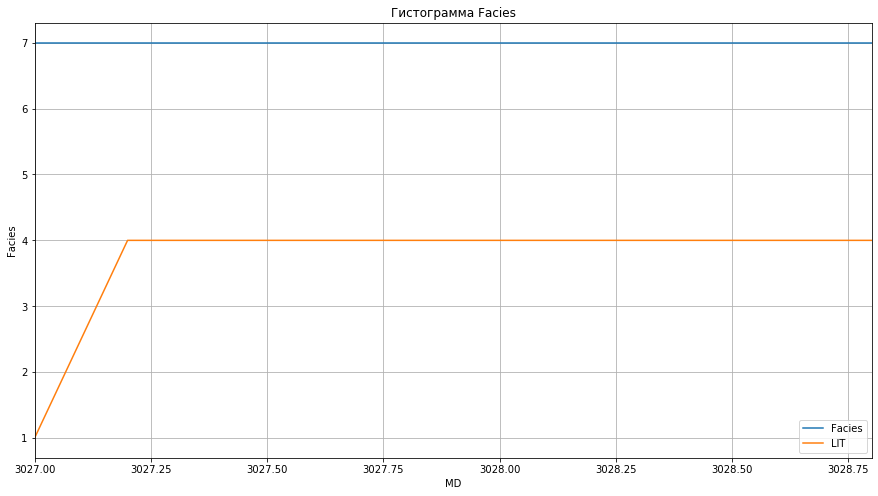

BK  Facies         GR        LIT          MD       NKTB  \
count  10.000000    10.0  10.000000  10.000000    10.00000  10.000000   
mean   21.538000     7.0   5.439000   3.100000  2686.10000   4.378000   
std     5.013364     0.0   0.237555   1.449138     0.60553   0.254375   
min    17.910000     7.0   5.110000   1.000000  2685.20000   4.010000   
25%    18.105000     7.0   5.245000   1.750000  2685.65000   4.155000   
50%    18.550000     7.0   5.450000   4.000000  2686.10000   4.465000   
75%    22.932500     7.0   5.607500   4.000000  2686.55000   4.592500   
max    31.020000     7.0   5.760000   4.000000  2687.00000   4.660000   

              SP  
count  10.000000  
mean   56.468000  
std     1.444498  
min    54.530000  
25%    55.017500  
50%    56.735000  
75%    57.685000  
max    58.100000

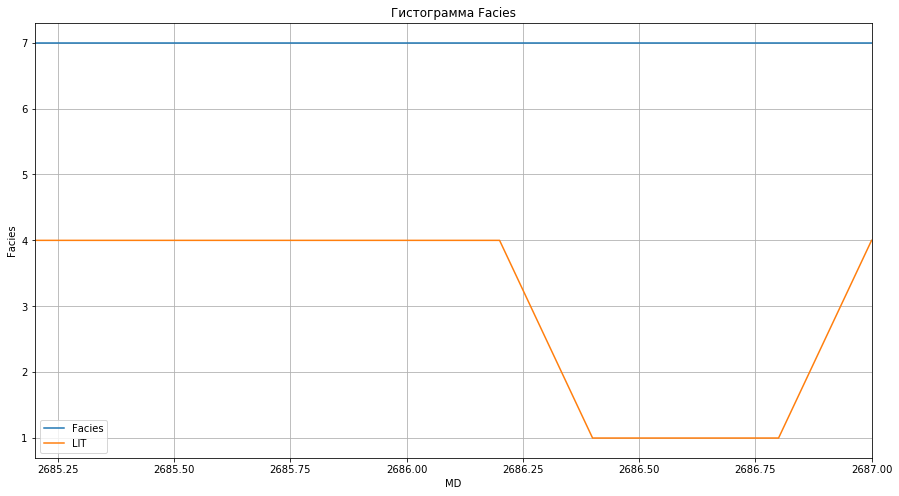

BK  Facies         GR        LIT          MD       NKTB  \
count  10.000000    10.0  10.000000  10.000000    10.00000  10.000000   
mean   12.947000     7.0   6.618000   3.400000  2533.30000   4.608401   
std     1.754461     0.0   0.225822   1.264911     0.60553   0.137965   
min    10.510000     7.0   6.190000   1.000000  2532.40000   4.399399   
25%    11.395000     7.0   6.525000   4.000000  2532.85000   4.509929   
50%    12.755000     7.0   6.570000   4.000000  2533.30000   4.647254   
75%    14.560000     7.0   6.730000   4.000000  2533.75000   4.687446   
max    15.200000     7.0   6.950000   4.000000  2534.20000   4.787928   

               SP  
count   10.000000  
mean   104.726730  
std      2.837119  
min    100.503800  
25%    102.550925  
50%    104.916750  
75%    106.337575  
max    109.643300

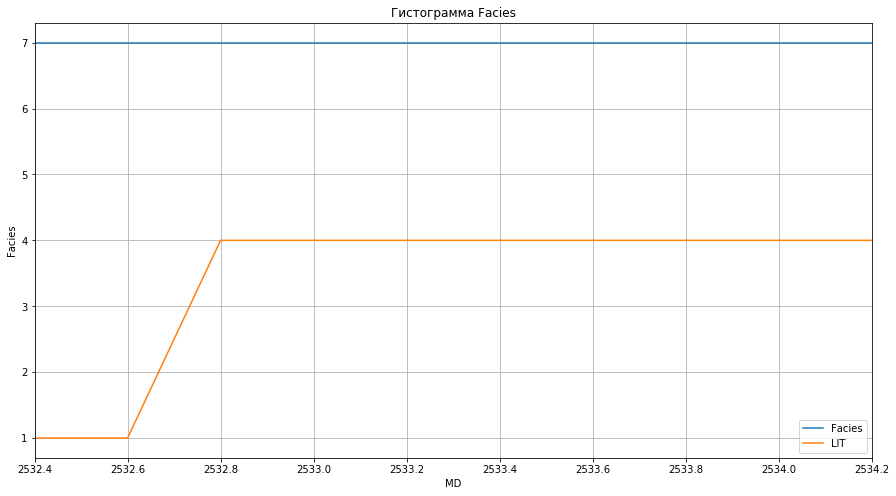

BK  Facies         GR        LIT          MD       NKTB  \
count  10.000000    10.0  10.000000  10.000000    10.00000  10.000000   
mean   15.696600     7.0   9.463500   2.400000  2543.10000   4.529226   
std     3.907839     0.0   1.548501   1.173788     0.60553   0.339159   
min     9.588000     7.0   7.285000   1.000000  2542.20000   4.071074   
25%    12.998500     7.0   8.290750   2.000000  2542.65000   4.213605   
50%    16.073500     7.0   9.436000   2.000000  2543.10000   4.555236   
75%    17.511250     7.0  10.304500   3.500000  2543.55000   4.802448   
max    21.295000     7.0  12.132000   4.000000  2544.00000   4.993922   

               SP  
count   10.000000  
mean   165.482570  
std      0.909403  
min    164.600800  
25%    164.735975  
50%    165.278350  
75%    166.017875  
max    167.293400

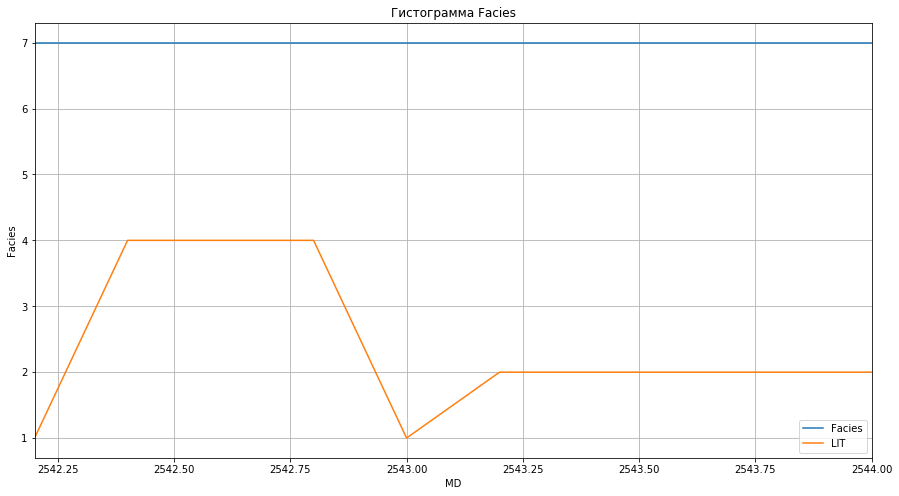

BK  Facies         GR        LIT          MD       NKTB  \
count  10.000000    10.0  10.000000  10.000000    10.00000  10.000000   
mean    9.495000     7.0  12.014000   1.300000  2598.90000   4.046500   
std     1.359356     0.0   1.469264   0.483046     0.60553   0.339133   
min     7.150000     7.0  10.050000   1.000000  2598.00000   3.532000   
25%     8.637500     7.0  10.822500   1.000000  2598.45000   3.808500   
50%     9.145000     7.0  11.860000   1.000000  2598.90000   4.085000   
75%    10.697500     7.0  13.230000   1.750000  2599.35000   4.165500   
max    11.420000     7.0  14.350000   2.000000  2599.80000   4.603000   

               SP  
count   10.000000  
mean   151.930860  
std      2.476179  
min    148.578500  
25%    149.913500  
50%    151.868750  
75%    154.039900  
max    155.329800

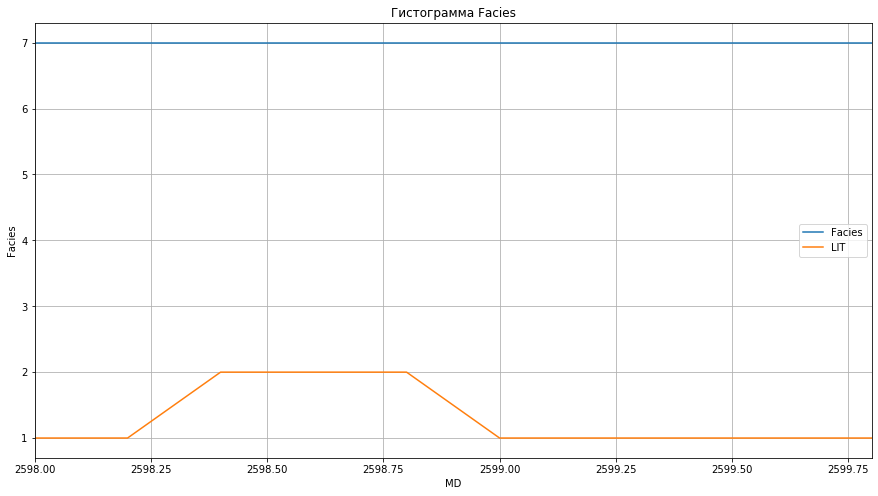

BK  Facies         GR       LIT           MD       NKTB  \
count  20.000000    20.0  20.000000  20.00000    20.000000  20.000000   
mean    9.169650     7.0   9.137600   3.40000  2559.900000   4.670813   
std     3.973697     0.0   1.731045   1.46539    13.350734   0.620500   
min     4.283000     7.0   7.474000   1.00000  2546.000000   3.624730   
25%     6.461250     7.0   8.154500   3.25000  2546.950000   4.208962   
50%     8.616500     7.0   8.472000   4.00000  2559.900000   4.680837   
75%    11.057500     7.0   9.328000   4.00000  2572.850000   5.279678   
max    20.822000     7.0  13.326000   5.00000  2573.800000   5.490851   

               SP  
count   20.000000  
mean    93.710867  
std      5.306085  
min     87.408290  
25%     89.523000  
50%     92.228405  
75%     98.114060  
max    102.419000

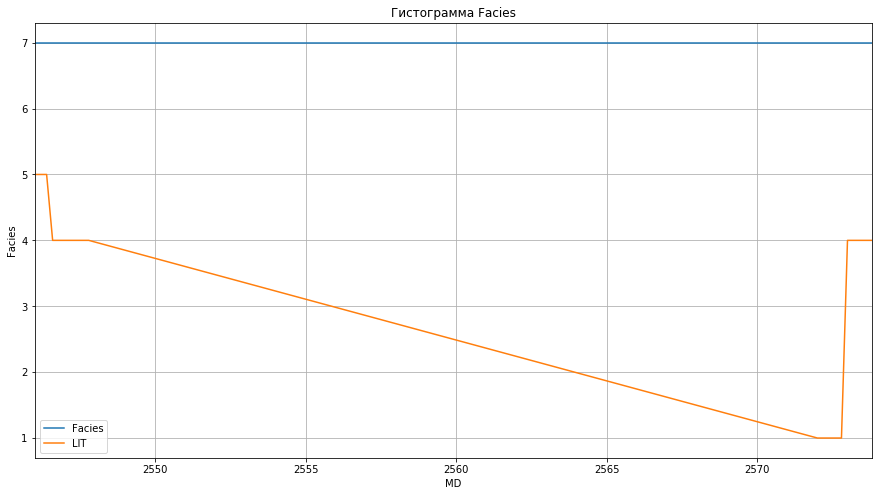

BK  Facies         GR        LIT          MD       NKTB  \
count  10.000000    10.0  10.000000  10.000000    10.00000  10.000000   
mean    5.930400     7.0  12.009500   1.300000  2616.90000   4.167127   
std     1.174973     0.0   1.449775   0.483046     0.60553   0.497990   
min     3.929000     7.0   9.568000   1.000000  2616.00000   3.645300   
25%     5.407000     7.0  10.901500   1.000000  2616.45000   3.667277   
50%     5.992000     7.0  12.324000   1.000000  2616.90000   4.150622   
75%     6.506250     7.0  12.710000   1.750000  2617.35000   4.557870   
max     7.997000     7.0  14.134000   2.000000  2617.80000   5.037478   

               SP  
count   10.000000  
mean   186.135150  
std      3.937699  
min    180.300100  
25%    183.982100  
50%    186.129200  
75%    187.752375  
max    193.489400

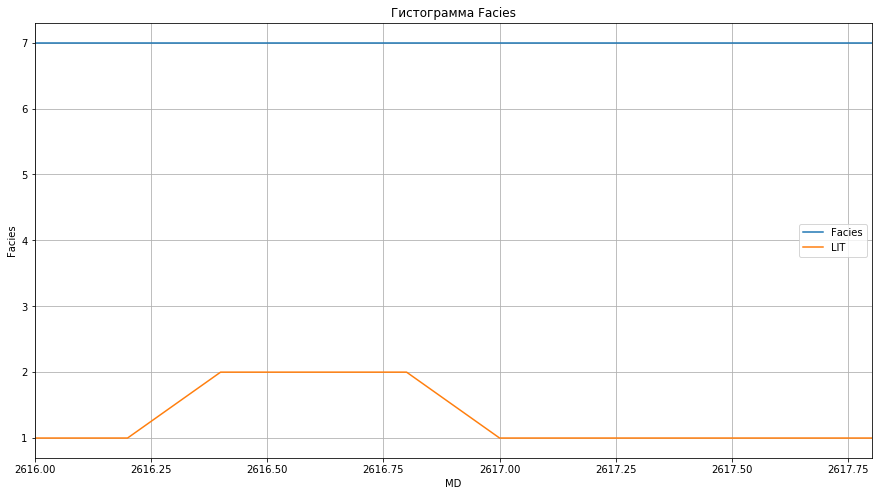

BK  Facies         GR        LIT          MD       NKTB  \
count  10.00000    10.0  10.000000  10.000000    10.00000  10.000000   
mean   13.23400     7.0   6.593000   3.700000  2533.40000   4.599692   
std     1.75374     0.0   0.151716   0.948683     0.60553   0.119141   
min    10.86000     7.0   6.320000   1.000000  2532.50000   4.406098   
25%    11.71500     7.0   6.528750   4.000000  2532.95000   4.516627   
50%    13.16500     7.0   6.625000   4.000000  2533.40000   4.590314   
75%    14.82750     7.0   6.720000   4.000000  2533.85000   4.697495   
max    15.65000     7.0   6.745000   4.000000  2534.30000   4.781229   

               SP  
count   10.000000  
mean   104.300850  
std      2.612602  
min    100.971900  
25%    101.724025  
50%    104.602350  
75%    106.020675  
max    108.541500

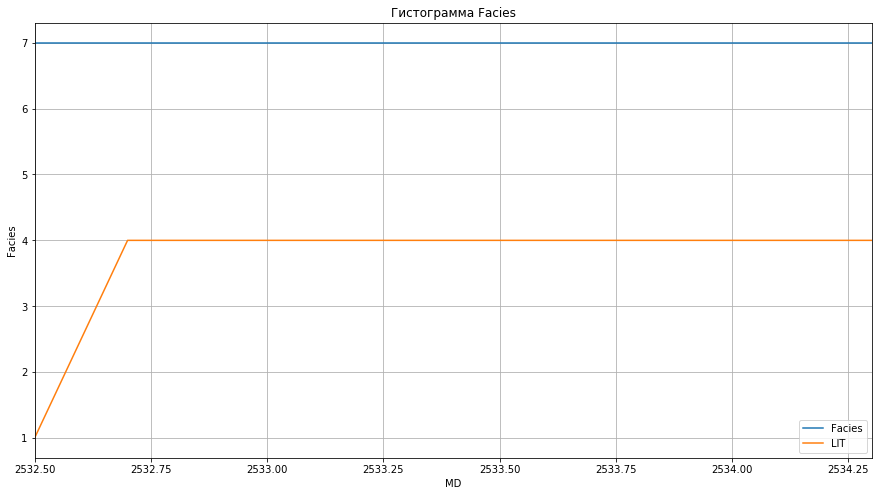

[        BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName
 0     4.42   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521
 1     4.30   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521
 2     4.31   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521
 3     4.28   -9999  13.03  -9999 -9999  2011.6  2.989185   97.86  spk1521
 4     4.26   -9999  12.94  -9999 -9999  2011.8  2.968678   98.15  spk1521
 ...    ...     ...    ...    ...   ...     ...       ...     ...      ...
 5406  7.85   -9999  18.86  UV1_3 -9999  3092.2  3.586331  131.68  spk1521
 5407  7.84   -9999  18.64  UV1_3 -9999  3092.4  3.550309  132.38  spk1521
 5408  7.85   -9999  18.49  UV1_3 -9999  3092.6  3.495778  132.12  spk1521
 5409  7.84   -9999  18.49  UV1_3 -9999  3092.8  3.675269  131.83  spk1521
 5410  7.84   -9999  18.49  UV1_3 -9999  3093.0  3.675269  131.83  spk1521
 
 [5411 rows x 9 columns],
          BK  Facies       GR  LAYER   LIT      MD     NKTB     SP wellN

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
def get_well_with_7(all_well_df):
    wall_names_ = all_well_df[all_well_df['Facies'] == 7]['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def filter_start_7_and_change_facies(wells, period):
    def change_facies(row):
        if row['is_middle'] == 49:
            return 3
        
        undefined_value = -9999
        if row["Facies"] == 7:
            return row["Facies"]
        if row["Facies"] > -1:
            return 3
        return row["Facies"]

    results = []
    wells_copy = wells.copy()
    for well in wells_copy:
        well['shift_up'] = well["Facies"].shift(period)
        well['is_middle'] = well['shift_up'] * well["Facies"]
        well = well.fillna(0)
        display(well[well['is_middle'] == 49].describe())
        well["Facies"] = well.apply(change_facies, axis=1)
        del well['shift_up']
        del well['is_middle']
        print(well)
        results.append(well)
    return results

def filter_middle_7(wells, period):
    results = []
    wells_copy = wells.copy()
    for well in wells_copy:
        well['shift_up'] = well["Facies"].shift(period)
        well['shift_dw'] = well["Facies"].shift(-period)
        well['is_middle'] = well['shift_up'] * well['shift_dw']
        well = well.fillna(0)
        display(well[well['is_middle'] == 49].describe())
        well = well[well['is_middle'] != 49]
        del well['shift_up']
        del well['shift_dw']
        del well['is_middle']
        results.append(well)
    return results
        
def well_with_7(wells):
    wells_copy = wells.copy()

    for well in wells_copy:
        well = well[well["Facies"] == 7]
        well = well[well["Facies"] < 13]
        display(well.describe())
        well_name = well['wellName'].unique()
        
        well.plot(x='MD', y=['Facies', 'LIT'], figsize=(15,8), grid=True)
        plt.xlabel('MD')
        plt.ylabel('Facies')
        plt.title(well_name + ' Facies')

        plt.title("Гистограмма Facies")
        #well['Facies'].hist(figsize=(15,8), x=well['MD'])
        plt.show()
        
    return wells

wells_with_7 = get_well_with_7(for_ml)
wells_with_7_filered = filter_start_7_and_change_facies(wells_with_7, 10)
well_with_7(wells_with_7_filered)

In [182]:
def get_well_with_distance_features(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'SP')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'SP')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy

def get_well_with_features_df(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    
    not_change_null = ['wellName', 'Facies', 'MD', 'LIT']
    wells_return = []
    import math
    for well in wells:
        print(well.head())
        well_copy = well.copy()  
        
        well_copy = get_well_with_distance_features(well_copy)

        wells_return.append(well_copy)
    return wells_return

def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x

 

def get_well_with_features_df1(wells):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    
    not_change_null = ['wellName', 'Facies', 'MD', 'LIT', 'LAYER']
    wells_return = []
    import math
    for well in wells:
        print(well.head())
        well_copy = well.copy()  
        from talib import MA_Type


        well_copy['SP'] = well_copy['SP'].apply(change_null)
        well_copy['GR'] = well_copy['GR'].apply(change_null)
        well_copy['BK'] = well_copy['BK'].apply(change_null)
        well_copy['NKTB'] = well_copy['NKTB'].apply(change_null)
        
        
        upper, middle, lower = talib.BBANDS(well_copy['NKTB'].apply(change_null),
                                timeperiod=16,
                                nbdevup=13,
                                nbdevdn=4,
                                matype=talib.MA_Type.EMA)
        well_copy['NKTB_lower'] = lower

        upper, middle, lower = talib.BBANDS(well_copy['NKTB'].apply(change_null),
                                timeperiod=31)
        well_copy['NKTB_lower_two'] = lower
        well_copy['NKTB_lower_shift'] = well_copy['NKTB_lower'].shift(-12)

        reverse = well_copy['BK'][::-1]
        upper, middle, lower = talib.BBANDS(reverse.apply(change_null), timeperiod=18)
        well_copy['BK_middle_reverse'] = middle[::-1]
        well_copy['BK_lower_reverse'] = lower[::-1]

        reverse = well_copy['GR'][::-1]
        upper, middle, lower = talib.BBANDS(reverse.apply(change_null), timeperiod=28)
        well_copy['GR_middle_reverse'] = middle[::-1]
        well_copy['GR_lower_reverse'] = lower[::-1]            

        well_copy['NKTB_SMA'] = talib.TRIX(well_copy['NKTB'], timeperiod=37)
        
        #print(well_copy['SP'])
        #print(well_copy['SP'][::-1])
        #reversed_arr = arr[::-1]


#         upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                                 timeperiod=28,
#                                 nbdevup=2,
#                                 nbdevdn=2,
#                                 matype=talib.MA_Type.EMA)

#         well_copy['SP_upper'] = upper
#         well_copy['SP_middle'] = middle
#         well_copy['SP_lower'] = lower

#         upper, middle, lower = talib.BBANDS(well_copy['NKTB'].apply(change_null),
#                                             timeperiod=16,
#                                             nbdevup=13,
#                                             nbdevdn=4,
#                                             matype=talib.MA_Type.EMA)
#         well_copy['NKTB_upper'] = upper
#         well_copy['NKTB_middle'] = middle
#         well_copy['NKTB_lower'] = lower


#         upper, middle, lower = talib.BBANDS(well_copy['BK'].apply(change_null), timeperiod=21)
#         well_copy['BK_upper'] = upper
#         well_copy['BK_middle'] = middle
#         well_copy['BK_lower'] = lower

#         upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null), timeperiod=24)
#         well_copy['GR_upper'] = upper
#         well_copy['GR_middle'] = middle
#         well_copy['GR_lower'] = lower


#         well_copy['NKTB_upper_shift'] = well_copy['NKTB_upper'].shift(-12)
#         well_copy['NKTB_middle_shift'] = well_copy['NKTB_middle'].shift(-12)
#         well_copy['NKTB_lower_shift'] = well_copy['NKTB_lower'].shift(-12)


#         #display(well_copy)
#         #display(well_copy.describe())
#         for feature_name in well_copy.columns:
#             if feature_name not in not_change_null:
#                 well_copy[feature_name] = well_copy[feature_name].apply(change_null)

            #display(well_copy)
            #del well_copy['SP']
        #well_copy['GR_TRANGE'] = talib.TRANGE(upper, middle, middle)
        
        
#for name_feature in ['SP', 'GR', 'BK', 'NKTB']:
#     well_copy[name_feature + 'mom_25'] = talib.MOM(well_copy[name_feature], timeperiod=25)
#     well_copy[name_feature + 'sma'] = talib.SMA(well_copy[name_feature])
#     well_copy[name_feature + 'HT_DCPERIOD'] = talib.HT_DCPERIOD(well_copy[name_feature])
#     well_copy[name_feature + 'HT_TRENDMODE'] = talib.HT_TRENDMODE(well_copy[name_feature])
#     well_copy[name_feature + 'CMO_14'] = talib.CMO(well_copy[name_feature], timeperiod=14)
#     well_copy[name_feature + 'CMO_25'] = talib.CMO(well_copy[name_feature], timeperiod=25)
#     well_copy[name_feature + 'ROC_10'] = talib.ROC(well_copy[name_feature], timeperiod=10)
#     well_copy[name_feature + 'ROC_20'] = talib.ROC(well_copy[name_feature], timeperiod=20)
#     well_copy[name_feature + 'ROC_30'] = talib.ROC(well_copy[name_feature], timeperiod=30)
#     well_copy[name_feature + 'TRIX_30'] = talib.TRIX(well_copy[name_feature], timeperiod=30)
#     inphase, quadrature = talib.HT_PHASOR(well_copy[name_feature])
#     well_copy[name_feature + 'HT_PHASOR_inphase'] = inphase
#     well_copy[name_feature + 'HT_PHASOR_quadrature'] = quadrature
#     sine, leadsine = talib.HT_SINE(well_copy[name_feature])
#     well_copy[name_feature + 'HT_SINE_sine'] = sine
#     well_copy[name_feature + 'HT_SINE_leadsine'] = leadsine
#     well_copy[name_feature + 'APO_12_26'] = talib.APO(well_copy[name_feature], fastperiod=12, slowperiod=26, matype=0)
#     well_copy[name_feature + 'ADXR'] = talib.ADXR(upper, lower, middle, timeperiod=14)
#     upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)
#     well_copy[name_feature + 'upper_BBANDS_25'] = upper
#     well_copy[name_feature + 'middle_BBANDS_25'] = middle
#     well_copy[name_feature + 'lower_BBANDS_25'] = lower
# 
#     upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)
#     well_copy[name_feature + 'upper_BBANDS_10'] = upper
#     well_copy[name_feature + 'middle_BBANDS_10'] = middle
#     well_copy[name_feature + 'lower_BBANDS_10'] = lower
# 
#     upper, middle, lower = talib.BBANDS(well_copy[name_feature], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
#     well_copy[name_feature + 'upper_BBANDS_5'] = upper
#     well_copy[name_feature + 'middle_BBANDS_5'] = middle
#     well_copy[name_feature + 'lower_BBANDS_5'] = lower
# 
#     well_copy[name_feature + 'KAMA_30'] = talib.KAMA(well_copy[name_feature], timeperiod=30)
#     well_copy[name_feature + 'KAMA_20'] = talib.KAMA(well_copy[name_feature], timeperiod=20)
#     well_copy[name_feature + 'DEMA_20'] = talib.DEMA(well_copy[name_feature], timeperiod=20)
#     well_copy[name_feature + 'EMA_20'] = talib.EMA(well_copy[name_feature], timeperiod=20)
#     well_copy[name_feature + 'EMA_5'] = talib.EMA(well_copy[name_feature], timeperiod=5)
#     well_copy[name_feature + 'EMA_45'] = talib.EMA(well_copy[name_feature], timeperiod=45)
            
        for feature_name in well_copy.columns:
            if feature_name not in not_change_null:
                well_copy[feature_name] = well_copy[feature_name].apply(change_null)
            
        wells_return.append(well_copy)
    return wells_return

well_with_features = get_well_with_features_df1(wells_samples_df)
wells_with_7_filered = filter_start_7_and_change_facies(well_with_features, 10)
for_ml_preprocessing = pd.concat(wells_with_7_filered)
display(for_ml_preprocessing)

     BK  Facies     GR  LAYER   LIT      MD      NKTB     SP wellName
0  4.42   -9999  13.60  -9999 -9999  2011.0  2.968678  97.41  spk1521
1  4.30   -9999  13.51  -9999 -9999  2011.2  2.937724  97.02  spk1521
2  4.31   -9999  13.17  -9999 -9999  2011.4  2.973814  97.57  spk1521
3  4.28   -9999  13.03  -9999 -9999  2011.6  2.989185  97.86  spk1521
4  4.26   -9999  12.94  -9999 -9999  2011.8  2.968678  98.15  spk1521
         BK  Facies    GR  LAYER   LIT      MD  NKTB     SP wellName
14662  3.07   -9999  7.89  -9999 -9999  1850.2  2.06  96.22  spk1527
14663  2.92   -9999  8.02  -9999 -9999  1850.4  2.05  95.43  spk1527
14664  2.87   -9999  8.06  -9999 -9999  1850.6  2.03  96.24  spk1527
14665  2.83   -9999  8.17  -9999 -9999  1850.8  2.07  97.14  spk1527
14666  3.19   -9999  8.25  -9999 -9999  1851.0  2.12  97.49  spk1527
         BK  Facies     GR  LAYER  LIT      MD  NKTB      SP wellName
28515  2.35   -9999   9.14  -9999    1  1850.2  1.65  103.65  spk1769
28516  2.61   -9999   8.84

BK  Facies          GR         LIT           MD        NKTB  \
count  108.000000   108.0  108.000000  108.000000   108.000000  108.000000   
mean    11.468056     7.0    8.842130    4.157407  3039.700000    5.254800   
std      7.497654     0.0    1.129343    0.725530     6.264184    0.442119   
min      4.020000     7.0    6.740000    1.000000  3029.000000    4.195716   
25%      5.982500     7.0    7.930000    4.000000  3034.350000    5.006951   
50%      9.435000     7.0    8.760000    4.000000  3039.700000    5.271079   
75%     13.785000     7.0    9.755000    5.000000  3045.050000    5.513675   
max     45.320000     7.0   11.990000    5.000000  3050.400000    6.191994   

               SP  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
count  108.000000  108.000000      108.000000        108.000000   
mean   100.723704    4.297102        4.552929          4.269601   
std      4.398595    0.483736        0.528605          0.484157   
min     95.560000    2.460831        3.372599          3.074869   
25%     97.717500    4.045119        4.300820          3.917917   
50%     99.475000    4.399987        4.812837          4.382266   
75%    102.207500    4.731873        4.910741          4.731873   
max    119.150000    4.944878        5.089826          4.944878   

       BK_middle_reverse  BK_lower_reverse  GR_middle_reverse  \
count         108.000000        108.000000         108.000000   
mean           11.148544          1.781593           9.309087   
std             4.980792          3.816118           1.307844   
min             5.093889         -4.819409           7.753214   
25%             7.277361         -1.431831           8.104643   
50%             8.965833          2.668407           9.166964   
75%            14.943472          4.770877          10.116250   
max            21.722222          7.915917          11.990714   

       GR_lower_reverse    NKTB_SMA  shift_up  is_middle  
count        108.000000  108.000000     108.0      108.0  
mean           7.585320    0.284755       7.0       49.0  
std            1.004162    0.198054       0.0        0.0  
min            6.212521   -0.164685       7.0       49.0  
25%            6.684754    0.153201       7.0       49.0  
50%            7.674347    0.370014       7.0       49.0  
75%            8.463727    0.450769       7.0       49.0  
max            9.421357    0.484213       7.0       49.0

        BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName  \
0     4.42   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521   
1     4.30   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521   
2     4.31   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521   
3     4.28   -9999  13.03  -9999 -9999  2011.6  2.989185   97.86  spk1521   
4     4.26   -9999  12.94  -9999 -9999  2011.8  2.968678   98.15  spk1521   
...    ...     ...    ...    ...   ...     ...       ...     ...      ...   
5406  7.85   -9999  18.86  UV1_3 -9999  3092.2  3.586331  131.68  spk1521   
5407  7.84   -9999  18.64  UV1_3 -9999  3092.4  3.550309  132.38  spk1521   
5408  7.85   -9999  18.49  UV1_3 -9999  3092.6  3.495778  132.12  spk1521   
5409  7.84   -9999  18.49  UV1_3 -9999  3092.8  3.675269  131.83  spk1521   
5410  7.84   -9999  18.49  UV1_3 -9999  3093.0  3.675269  131.83  spk1521   

       NKTB_lower  NKTB_lower_two  NKTB_lower_shift  BK_middle_reverse  \
0

BK  Facies         GR        LIT           MD       NKTB  \
count  62.000000    62.0  62.000000  62.000000    62.000000  62.000000   
mean   17.811774     7.0   5.752258   3.419355  2693.300000   4.542258   
std     5.783489     0.0   0.825486   1.194913     3.608324   0.562044   
min     5.690000     7.0   5.080000   1.000000  2687.200000   3.440000   
25%    14.150000     7.0   5.322500   4.000000  2690.250000   4.195000   
50%    18.565000     7.0   5.545000   4.000000  2693.300000   4.400000   
75%    20.832500     7.0   5.687500   4.000000  2696.350000   4.807500   
max    32.980000     7.0   9.020000   4.000000  2699.400000   5.760000   

              SP  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
count  62.000000   62.000000       62.000000         62.000000   
mean   59.326290    3.356495        3.816992          3.126272   
std     6.309395    0.556666        0.217430          0.596162   
min    52.900000    2.232875        3.431467          2.232875   
25%    56.620000    3.083635        3.599461          2.667392   
50%    57.665000    3.451293        3.901249          3.141342   
75%    58.745000    3.862677        4.001619          3.576047   
max    81.730000    4.111131        4.084697          4.108727   

       BK_middle_reverse  BK_lower_reverse  GR_middle_reverse  \
count          62.000000         62.000000          62.000000   
mean           16.206559          9.636126           5.928583   
std             4.992175          5.375245           0.456136   
min             9.307778          0.761006           5.351786   
25%            10.682778          4.583163           5.503750   
50%            16.155833         11.297340           5.867500   
75%            21.320417         14.075642           6.295804   
max            22.398889         17.010846           6.665357   

       GR_lower_reverse   NKTB_SMA  shift_up  is_middle  
count         62.000000  62.000000      62.0       62.0  
mean           4.767276   0.620221       7.0       49.0  
std            0.436835   0.266047       0.0        0.0  
min            4.049923   0.075788       7.0       49.0  
25%            4.270048   0.396517       7.0       49.0  
50%            5.055220   0.751224       7.0       49.0  
75%            5.126815   0.820406       7.0       49.0  
max            5.349184   0.923063       7.0       49.0

         BK  Facies       GR  LAYER   LIT      MD     NKTB     SP wellName  \
14662  3.07   -9999     7.89  -9999 -9999  1850.2     2.06  96.22  spk1527   
14663  2.92   -9999     8.02  -9999 -9999  1850.4     2.05  95.43  spk1527   
14664  2.87   -9999     8.06  -9999 -9999  1850.6     2.03  96.24  spk1527   
14665  2.83   -9999     8.17  -9999 -9999  1850.8     2.07  97.14  spk1527   
14666  3.19   -9999     8.25  -9999 -9999  1851.0     2.12  97.49  spk1527   
...     ...     ...      ...    ...   ...     ...      ...    ...      ...   
19260  7.56   -9999 -9999.00    UV2 -9999  2769.8 -9999.00  76.04  spk1527   
19261  8.10   -9999 -9999.00    UV2 -9999  2770.0 -9999.00  77.77  spk1527   
19262  8.20   -9999 -9999.00    UV2 -9999  2770.2 -9999.00  79.66  spk1527   
19263  8.20   -9999 -9999.00    UV2 -9999  2770.4 -9999.00  83.38  spk1527   
19264  8.20   -9999 -9999.00    UV2 -9999  2770.6 -9999.00  83.38  spk1527   

        NKTB_lower  NKTB_lower_two  NKTB_lower_shift  BK_middle

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

            BK  Facies       GR  LAYER   LIT      MD     NKTB       SP  \
28515     2.35   -9999     9.14  -9999     1  1850.2     1.65   103.65   
28516     2.61   -9999     8.84  -9999     1  1850.4     1.71   104.29   
28517     3.30   -9999     9.02  -9999     1  1850.6     1.72   104.68   
28518     3.34   -9999     9.84  -9999     1  1850.8     1.70   104.90   
28519     2.58   -9999    10.17  -9999     1  1851.0     1.70   104.73   
...        ...     ...      ...    ...   ...     ...      ...      ...   
32680 -9999.00   -9999 -9999.00    UV2 -9999  2683.2 -9999.00 -9999.00   
32681 -9999.00   -9999 -9999.00    UV2 -9999  2683.4 -9999.00 -9999.00   
32682 -9999.00   -9999 -9999.00    UV2 -9999  2683.6 -9999.00 -9999.00   
32683 -9999.00   -9999 -9999.00    UV2 -9999  2683.8 -9999.00 -9999.00   
32684 -9999.00   -9999 -9999.00    UV2 -9999  2684.0 -9999.00 -9999.00   

      wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
28515  spk1769 -9999.000000         -9999.0   

BK  Facies         GR        LIT           MD       NKTB  \
count  44.000000    44.0  44.000000  44.000000    44.000000  44.000000   
mean   14.638182     7.0   6.369773   3.295455  2538.700000   4.539769   
std     3.378041     0.0   0.599308   1.001848     2.569047   0.227740   
min     7.880000     7.0   5.560000   1.000000  2534.400000   4.104653   
25%    11.492500     7.0   5.940000   2.000000  2536.550000   4.359206   
50%    15.505000     7.0   6.250000   4.000000  2538.700000   4.519977   
75%    17.237500     7.0   6.650000   4.000000  2540.850000   4.710892   
max    20.460000     7.0   8.830000   4.000000  2543.000000   5.029084   

               SP  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
count   44.000000   44.000000       44.000000         44.000000   
mean    98.821727    3.871232        3.598763          3.420054   
std      8.349744    0.261820        0.729948          0.911771   
min     87.790760    3.037915        1.860506          1.508624   
25%     90.554348    3.686408        3.062369          3.443846   
50%     98.845645    3.924566        4.070602          3.774554   
75%    106.502300    4.007750        4.085952          4.007750   
max    115.737500    4.354189        4.139509          4.354189   

       BK_middle_reverse  BK_lower_reverse  GR_middle_reverse  \
count          44.000000         44.000000          44.000000   
mean           13.252361          6.704355           7.198490   
std             2.487448          3.557734           0.798367   
min             8.195556          0.453064           6.205000   
25%            12.030556          4.727910           6.388214   
50%            13.017778          7.032133           7.248393   
75%            14.989722          8.179522           8.030446   
max            17.531111         14.282399           8.272143   

       GR_lower_reverse   NKTB_SMA  shift_up  is_middle  
count         44.000000  44.000000      44.0       44.0  
mean           4.302616   1.053568       7.0       49.0  
std            0.988326   0.285020       0.0        0.0  
min            2.806315   0.631084       7.0       49.0  
25%            3.606213   0.791486       7.0       49.0  
50%            4.056985   1.037994       7.0       49.0  
75%            5.443839   1.336067       7.0       49.0  
max            5.565766   1.444480       7.0       49.0

         BK  Facies       GR  LAYER   LIT      MD      NKTB         SP  \
34747  7.05   -9999     8.85  -9999 -9999  1850.2  4.560170   105.8819   
34749  7.57   -9999     8.42  -9999 -9999  1850.4  4.801326   106.8136   
34751  7.62   -9999     8.00  -9999 -9999  1850.6  4.653953   109.3252   
34753  7.08   -9999     9.25  -9999 -9999  1850.8  4.426194   112.7668   
34755  6.18   -9999     9.48  -9999 -9999  1851.0  4.292219   115.9084   
...     ...     ...      ...    ...   ...     ...       ...        ...   
42057  5.59   -9999    10.06  UV1_2     1  2581.2  4.506579 -9999.0000   
42059  5.59   -9999     9.97  UV1_2     1  2581.4  4.452989 -9999.0000   
42061  5.59   -9999    10.31  UV1_2     1  2581.6  4.452989 -9999.0000   
42063  5.59   -9999    10.14  UV1_2     1  2581.8  4.372604 -9999.0000   
42065  5.59   -9999 -9999.00  UV1_2     1  2582.0  4.386001 -9999.0000   

      wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
34747   spk400 -9999.000000    -9999.000000   

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

            BK  Facies       GR  LAYER   LIT      MD     NKTB         SP  \
43117    13.62   -9999     3.97  -9999 -9999  1850.2     2.79    53.5451   
43118    13.86   -9999     4.11  -9999 -9999  1850.4     2.83    53.8551   
43119    14.00   -9999     4.13  -9999 -9999  1850.6     2.86    54.1751   
43120    14.12   -9999     4.03  -9999 -9999  1850.8     2.86    54.1751   
43121    14.26   -9999     4.14  -9999 -9999  1851.0     2.87    54.1751   
...        ...     ...      ...    ...   ...     ...      ...        ...   
46672 -9999.00   -9999 -9999.00  UV1_3     1  2561.2 -9999.00 -9999.0000   
46673 -9999.00   -9999 -9999.00  UV1_3     1  2561.4 -9999.00 -9999.0000   
46674 -9999.00   -9999 -9999.00  UV1_3     1  2561.6 -9999.00 -9999.0000   
46675 -9999.00   -9999 -9999.00  UV1_3     1  2561.8 -9999.00 -9999.0000   
46676 -9999.00   -9999 -9999.00  UV1_3     1  2562.0 -9999.00 -9999.0000   

      wellName  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
43117   spk402     -999

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

         BK  Facies       GR  LAYER   LIT      MD         NKTB          SP  \
47728   6.6   -9999     6.48  -9999 -9999  1850.2     2.965058    58.25299   
47729   7.7   -9999     7.37  -9999 -9999  1850.4     2.965058    49.36739   
47730   8.7   -9999     8.07  -9999 -9999  1850.6     2.991365    35.48180   
47731   9.5   -9999     8.54  -9999 -9999  1850.8     3.035210    29.28621   
47732   9.9   -9999     7.91  -9999 -9999  1851.0     3.087824    25.88061   
...     ...     ...      ...    ...   ...     ...          ...         ...   
51863  13.6   -9999 -9999.00    UV3 -9999  2677.2 -9999.000000 -9999.00000   
51864  15.2   -9999 -9999.00    UV3 -9999  2677.4 -9999.000000 -9999.00000   
51865  18.1   -9999 -9999.00    UV3 -9999  2677.6 -9999.000000 -9999.00000   
51866  19.5   -9999 -9999.00    UV3 -9999  2677.8 -9999.000000 -9999.00000   
51867  19.5   -9999 -9999.00    UV3 -9999  2678.0 -9999.000000 -9999.00000   

      wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

           BK  Facies      GR  LAYER   LIT      MD       NKTB          SP  \
52919     7.8   -9999    10.8  -9999 -9999  1850.2     2.4925   113.99100   
52920     7.2   -9999    11.5  -9999 -9999  1850.4     2.4025   106.19200   
52921     6.5   -9999    11.2  -9999 -9999  1850.6     2.5225    93.89297   
52922     5.9   -9999    11.9  -9999 -9999  1850.8     2.5600    92.69396   
52923     5.7   -9999    12.6  -9999 -9999  1851.0     2.6275    99.89494   
...       ...     ...     ...    ...   ...     ...        ...         ...   
56839    28.5   -9999 -9999.0    UV3 -9999  2634.2     1.9300 -9999.00000   
56840    28.5   -9999 -9999.0    UV3 -9999  2634.4     1.9300 -9999.00000   
56841 -9999.0   -9999 -9999.0    UV3 -9999  2634.6 -9999.0000 -9999.00000   
56842 -9999.0   -9999 -9999.0    UV3 -9999  2634.8 -9999.0000 -9999.00000   
56843 -9999.0   -9999 -9999.0    UV3 -9999  2635.0 -9999.0000 -9999.00000   

      wellName    NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
52919  sp

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

         BK  Facies      GR  LAYER   LIT      MD         NKTB          SP  \
57915   8.1   -9999     8.3  -9999 -9999  1850.2     3.967212    66.05995   
57916  10.3   -9999     8.5  -9999 -9999  1850.4     4.153172    59.44989   
57917   9.2   -9999     8.3  -9999 -9999  1850.6     3.765081    53.47982   
57918   8.3   -9999     8.5  -9999 -9999  1850.8     3.312307    49.70975   
57919   8.3   -9999     8.7  -9999 -9999  1851.0     3.288051    47.50969   
...     ...     ...     ...    ...   ...     ...          ...         ...   
62045  11.3   -9999 -9999.0    UV3 -9999  2676.2 -9999.000000 -9999.00000   
62046  11.9   -9999 -9999.0    UV3 -9999  2676.4 -9999.000000 -9999.00000   
62047  13.4   -9999 -9999.0    UV3 -9999  2676.6 -9999.000000 -9999.00000   
62048  14.5   -9999 -9999.0    UV3 -9999  2676.8 -9999.000000 -9999.00000   
62049  14.7   -9999 -9999.0    UV3 -9999  2677.0 -9999.000000 -9999.00000   

      wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
57915  spk

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

         BK  Facies       GR  LAYER   LIT      MD      NKTB          SP  \
63001   4.3   -9999     8.20  -9999 -9999  1850.2  3.011470    96.55894   
63002   6.4   -9999     8.56  -9999 -9999  1850.4  3.150384    92.05772   
63003   6.6   -9999     8.76  -9999 -9999  1850.6  3.141123    99.75651   
63004   4.2   -9999     8.36  -9999 -9999  1850.8  3.029992   110.15530   
63005   4.0   -9999     8.76  -9999 -9999  1851.0  2.946643   113.15410   
...     ...     ...      ...    ...   ...     ...       ...         ...   
66991  21.6   -9999    11.20    UV3 -9999  2648.2  2.798468 -9999.00000   
66992  22.3   -9999 -9999.00    UV3 -9999  2648.4  2.585466 -9999.00000   
66993  21.6   -9999 -9999.00    UV3 -9999  2648.6  2.622510 -9999.00000   
66994  22.3   -9999 -9999.00    UV3 -9999  2648.8  2.983687 -9999.00000   
66995  22.3   -9999 -9999.00    UV3 -9999  2649.0  3.530084 -9999.00000   

      wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
63001  spk409R -9999.000000    -99

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

          BK  Facies     GR  LAYER   LIT      MD      NKTB         SP  \
67922   5.74   -9999   8.58  -9999 -9999  1850.2  3.505265   82.97842   
67923   6.44   -9999   8.21  -9999 -9999  1850.4  3.497532   81.87230   
67924   7.96   -9999   7.90  -9999 -9999  1850.6  3.427938   81.06616   
67925   9.00   -9999   7.57  -9999 -9999  1850.8  3.327412   80.56004   
67926   9.47   -9999   7.32  -9999 -9999  1851.0  3.304214   80.25391   
...      ...     ...    ...    ...   ...     ...       ...        ...   
71727  11.22   -9999  13.16  UV1_3 -9999  2611.2  4.154813  107.00140   
71728  11.22   -9999  12.68  UV1_3 -9999  2611.4  4.062021  107.20140   
71729  10.75   -9999  13.02  UV1_3 -9999  2611.6  4.054288  107.30140   
71730  10.40   -9999  12.66  UV1_3 -9999  2611.8  4.116149  107.60140   
71731  10.40   -9999  12.81  UV1_3 -9999  2612.0  4.038822  107.20140   

      wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
67922  spk420R -9999.000000    -9999.000000      -9999.000

BK  Facies         GR        LIT           MD       NKTB  \
count  38.000000    38.0  38.000000  38.000000    38.000000  38.000000   
mean   13.392211     7.0   9.481658   2.552632  2547.900000   4.513306   
std     4.518004     0.0   2.522998   1.588767     2.222611   0.533147   
min     6.766000     7.0   6.494000   1.000000  2544.200000   3.405003   
25%    10.300750     7.0   7.640500   1.000000  2546.050000   4.200295   
50%    11.607500     7.0   8.879000   2.000000  2547.900000   4.460954   
75%    15.951751     7.0   9.999250   4.000000  2549.750000   4.824493   
max    26.099001     7.0  15.775000   5.000000  2551.600000   5.706024   

               SP  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
count   38.000000   38.000000       38.000000         38.000000   
mean   164.334784    3.061669        3.489710          2.788136   
std     14.185300    0.551329        0.452846          0.688449   
min    150.352700    1.520530        2.636362          1.520530   
25%    155.146025    2.947597        3.231769          2.318585   
50%    159.797300    3.261944        3.740064          2.950129   
75%    166.517800    3.432229        3.825542          3.432229   
max    205.800300    3.654892        3.919799          3.654892   

       BK_middle_reverse  BK_lower_reverse  GR_middle_reverse  \
count          38.000000         38.000000          38.000000   
mean           13.329478          3.532802          10.240770   
std             1.302960          1.564538           1.004741   
min            10.856833          1.796064           8.396214   
25%            12.450667          2.503172           9.557214   
50%            13.603111          2.883007          10.599714   
75%            14.222139          4.643781          11.122500   
max            15.467667          6.637419          11.338321   

       GR_lower_reverse   NKTB_SMA  shift_up  is_middle  
count         38.000000  38.000000      38.0       38.0  
mean           4.771513   0.418400       7.0       49.0  
std            0.740314   0.082013       0.0        0.0  
min            3.200377   0.260571       7.0       49.0  
25%            4.388503   0.381984       7.0       49.0  
50%            4.717644   0.389635       7.0       49.0  
75%            5.092114   0.465126       7.0       49.0  
max            6.110080   0.602300       7.0       49.0

           BK  Facies      GR  LAYER   LIT      MD      NKTB         SP  \
80982 -9999.0   -9999   8.489  -9999 -9999  1850.2  2.455534   204.3735   
80983 -9999.0   -9999   9.932  -9999 -9999  1850.4  2.610821   204.3428   
80984 -9999.0   -9999   9.726  -9999 -9999  1850.6  2.969090   204.7571   
80985 -9999.0   -9999   9.892  -9999 -9999  1850.8  2.499902   205.1724   
80986 -9999.0   -9999   9.189  -9999 -9999  1851.0  2.653525   204.6957   
...       ...     ...     ...    ...   ...     ...       ...        ...   
84977 -9999.0   -9999  10.250    UV3     1  2649.2  4.075511 -9999.0000   
84978 -9999.0   -9999   8.802    UV3     1  2649.4  3.850344 -9999.0000   
84979 -9999.0   -9999   8.636    UV3     1  2649.6  4.006186 -9999.0000   
84980 -9999.0   -9999   8.879    UV3     1  2649.8  4.025042 -9999.0000   
84981 -9999.0   -9999   8.310    UV3     1  2650.0  4.123760 -9999.0000   

      wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
80982  spk424R -9999.000000    -99

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

             BK  Facies      GR  LAYER   LIT      MD      NKTB         SP  \
91755 -9999.000   -9999  10.822  -9999 -9999  1850.2  3.568865   113.7384   
91756 -9999.000   -9999  10.564  -9999 -9999  1850.4  3.628613   114.5806   
91757 -9999.000   -9999  10.438  -9999 -9999  1850.6  3.571381   115.0468   
91758 -9999.000   -9999  10.233  -9999 -9999  1850.8  3.326100   115.5890   
91759 -9999.000   -9999  10.199  -9999 -9999  1851.0  3.358804   116.3082   
...         ...     ...     ...    ...   ...     ...       ...        ...   
95605     6.424   -9999  11.788  UV1_3     1  2620.2  3.665091 -9999.0000   
95606     6.424   -9999  12.247  UV1_3     1  2620.4  3.520438 -9999.0000   
95607     6.424   -9999  12.385  UV1_3     1  2620.6  3.611633 -9999.0000   
95608     6.424   -9999  13.111  UV1_3     1  2620.8  3.620437 -9999.0000   
95609     6.424   -9999  12.588  UV1_3     1  2621.0  3.437420 -9999.0000   

      wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
91755  spk

BK  Facies         GR        LIT           MD       NKTB  \
count  64.000000    64.0  64.000000  64.000000    64.000000  64.000000   
mean    9.111562     7.0   9.176719   3.078125  2606.300000   5.169891   
std     4.264764     0.0   1.476224   1.576662     3.723797   0.580806   
min     4.260000     7.0   6.980000   1.000000  2600.000000   4.162000   
25%     6.147500     7.0   8.002500   1.000000  2603.150000   4.732500   
50%     7.330000     7.0   8.995000   4.000000  2606.300000   5.138500   
75%    10.340000     7.0  10.222500   4.000000  2609.450000   5.486750   
max    23.560000     7.0  13.270000   5.000000  2612.600000   6.773000   

               SP  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
count   64.000000   64.000000       64.000000         64.000000   
mean   143.026581    3.230546        3.868243          3.233006   
std      4.739720    0.361264        0.449997          0.379207   
min    132.504900    2.566472        3.243091          2.287693   
25%    138.794700    2.981614        3.457099          3.027314   
50%    143.360000    3.184127        4.011321          3.184127   
75%    146.352675    3.395045        4.318016          3.395045   
max    152.249000    4.197199        4.533339          4.197199   

       BK_middle_reverse  BK_lower_reverse  GR_middle_reverse  \
count          64.000000         64.000000          64.000000   
mean           10.359505          1.001458           8.966624   
std             3.025783          2.300003           0.363608   
min             6.604444         -5.531053           8.133214   
25%             8.710278         -0.692219           8.750893   
50%             9.748333          1.946361           8.976071   
75%            10.566111          2.634691           9.219911   
max            18.823889          5.126034           9.750714   

       GR_lower_reverse   NKTB_SMA  shift_up  is_middle  
count         64.000000  64.000000      64.0       64.0  
mean           5.958550   0.159398       7.0       49.0  
std            0.760757   0.198640       0.0        0.0  
min            4.632999  -0.192713       7.0       49.0  
25%            5.358525  -0.013916       7.0       49.0  
50%            5.895825   0.225399       7.0       49.0  
75%            6.742231   0.330860       7.0       49.0  
max            7.059980   0.379170       7.0       49.0

             BK  Facies       GR  LAYER   LIT      MD   NKTB        SP  \
97482  -9999.00   -9999    11.05  -9999 -9999  1850.2  2.104  154.2310   
97483  -9999.00   -9999    10.93  -9999 -9999  1850.4  2.076  156.2784   
97484  -9999.00   -9999    10.86  -9999 -9999  1850.6  2.293  155.8158   
97485  -9999.00   -9999    10.94  -9999 -9999  1850.8  2.573  152.7332   
97486  -9999.00   -9999    10.80  -9999 -9999  1851.0  2.951  149.5206   
...         ...     ...      ...    ...   ...     ...    ...       ...   
101732    47.97   -9999 -9999.00      1     1  2700.2  2.811  149.9608   
101733    43.57   -9999 -9999.00      1     1  2700.4  3.168  149.5307   
101734    42.85   -9999 -9999.00      1     1  2700.6  3.063  148.4408   
101735    42.65   -9999 -9999.00      1     1  2700.8  3.252  143.3008   
101736    42.65   -9999 -9999.00      1     1  2701.0  3.252  143.3008   

       wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
97482   spk428R -9999.000000    -9999.000000 

BK  Facies          GR         LIT           MD        NKTB  \
count  102.000000   102.0  102.000000  102.000000   102.000000  102.000000   
mean    16.060686     7.0    8.180725    3.441176  2574.674510    5.149738   
std     23.458641     0.0    1.889095    1.445879    13.884871    0.921565   
min      4.443000     7.0    4.515000    1.000000  2548.000000    3.779132   
25%      6.935499     7.0    6.576000    2.000000  2574.450000    4.481659   
50%      8.500999     7.0    8.278500    4.000000  2579.500000    4.905788   
75%     12.895250     7.0    9.180000    4.000000  2584.550000    5.727798   
max    124.257000     7.0   12.554000    5.000000  2589.600000    7.856283   

               SP  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
count  102.000000  102.000000      102.000000        102.000000   
mean    90.954873    3.255228        3.636535          3.108383   
std      5.078713    1.087765        0.337308          1.062130   
min     77.529530   -0.152891        3.124670         -0.152891   
25%     87.920350    2.938624        3.497932          2.681404   
50%     91.107780    3.225348        3.598611          3.221488   
75%     94.429450    4.012542        3.679169          3.723673   
max    102.708100    4.898587        4.895525          4.898587   

       BK_middle_reverse  BK_lower_reverse  GR_middle_reverse  \
count         102.000000        102.000000         102.000000   
mean           16.149043         -8.049958           8.498118   
std            12.364924         19.949071           1.187205   
min             6.551556        -53.768627           6.176286   
25%             8.157097         -2.056709           7.716696   
50%            11.155055          1.444206           8.502679   
75%            16.000014          4.659813           9.290268   
max            46.059501          6.209902          11.482857   

       GR_lower_reverse    NKTB_SMA  shift_up  is_middle  
count        102.000000  102.000000     102.0      102.0  
mean           4.755923    0.269066       7.0       49.0  
std            1.452338    0.294027       0.0        0.0  
min            2.560621   -0.188988       7.0       49.0  
25%            3.652194   -0.039818       7.0       49.0  
50%            4.452066    0.288878       7.0       49.0  
75%            5.638225    0.563207       7.0       49.0  
max            8.556618    0.688860       7.0       49.0

              BK  Facies        GR  LAYER   LIT      MD      NKTB          SP  \
110987 -9999.000   -9999    11.469  -9999 -9999  1850.2  3.237063    96.87789   
110988 -9999.000   -9999    11.517  -9999 -9999  1850.4  3.258917   101.39630   
110989 -9999.000   -9999    11.062  -9999 -9999  1850.6  3.323053   103.94360   
110990 -9999.000   -9999    11.340  -9999 -9999  1850.8  3.287897   104.68800   
110991 -9999.000   -9999    11.157  -9999 -9999  1851.0  3.290273   104.21840   
...          ...     ...       ...    ...   ...     ...       ...         ...   
115247    10.713   -9999 -9999.000    UV3     1  2702.2  4.208130 -9999.00000   
115248    10.713   -9999 -9999.000    UV3     1  2702.4  4.190077 -9999.00000   
115249    10.713   -9999 -9999.000    UV3     1  2702.6  4.138768 -9999.00000   
115250    10.713   -9999 -9999.000    UV3     1  2702.8  4.062756 -9999.00000   
115251 -9999.000   -9999 -9999.000    UV3     1  2703.0  4.049453 -9999.00000   

       wellName   NKTB_lowe

BK  Facies         GR        LIT           MD       NKTB  \
count  83.000000    83.0  83.000000  83.000000    83.000000  83.000000   
mean    5.588470     7.0  10.866494   2.265060  2626.200000   4.392609   
std     0.961734     0.0   1.660552   1.362247     4.820788   0.368007   
min     4.249000     7.0   7.378000   1.000000  2618.000000   3.392938   
25%     4.908500     7.0   9.772000   1.000000  2622.100000   4.174543   
50%     5.384000     7.0  10.567000   2.000000  2626.200000   4.386240   
75%     5.995000     7.0  11.966500   4.000000  2630.300000   4.616475   
max     9.271000     7.0  15.165000   5.000000  2634.400000   5.353230   

               SP  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
count   83.000000   83.000000       83.000000         83.000000   
mean   169.821164    3.034361        3.531118          3.154261   
std     11.652999    0.331595        0.257324          0.255053   
min    145.466800    2.245775        2.921085          2.691299   
25%    162.728250    2.774430        3.495007          2.929328   
50%    167.751200    3.094353        3.593370          3.203947   
75%    179.747550    3.338383        3.675744          3.362625   
max    192.607000    3.526510        3.928373          3.609802   

       BK_middle_reverse  BK_lower_reverse  GR_middle_reverse  \
count          83.000000         83.000000          83.000000   
mean            5.787059          4.033820          11.210799   
std             0.583127          0.522132           0.583929   
min             4.777111          2.819862          10.355500   
25%             5.350722          3.539951          10.795036   
50%             5.802667          4.148133          11.204000   
75%             6.083417          4.468386          11.437946   
max             7.060278          4.865888          12.338500   

       GR_lower_reverse   NKTB_SMA  shift_up  is_middle  
count         83.000000  83.000000      83.0       83.0  
mean           8.244353   0.063183       7.0       49.0  
std            1.127444   0.066858       0.0        0.0  
min            6.811425  -0.166300       7.0       49.0  
25%            7.192527   0.043413       7.0       49.0  
50%            7.986664   0.070736       7.0       49.0  
75%            9.024353   0.115792       7.0       49.0  
max           10.404052   0.136542       7.0       49.0

            BK  Facies        GR  LAYER   LIT      MD      NKTB          SP  \
120898   8.200   -9999     6.850  -9999 -9999  1850.2  3.385164   101.91600   
120899   8.320   -9999     6.717  -9999 -9999  1850.4  3.483238    99.98422   
120900   8.760   -9999     6.744  -9999 -9999  1850.6  3.461112   100.51040   
120901   9.020   -9999     6.979  -9999 -9999  1850.8  3.634536   100.61460   
120902   8.960   -9999     7.102  -9999 -9999  1851.0  3.438985    99.59578   
...        ...     ...       ...    ...   ...     ...       ...         ...   
125090  10.595   -9999    12.056    UV3 -9999  2688.6  3.522109 -9999.00000   
125091  10.595   -9999    11.996    UV3 -9999  2688.8  3.378585 -9999.00000   
125092  10.595   -9999    12.002    UV3 -9999  2689.0  3.555000 -9999.00000   
125093  10.595   -9999 -9999.000    UV3 -9999  2689.2  3.735600 -9999.00000   
125094  10.595   -9999 -9999.000    UV3 -9999  2689.4  3.724238 -9999.00000   

       wellName   NKTB_lower  NKTB_lower_two  NKTB_

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

          BK  Facies       GR  LAYER   LIT      MD        NKTB      SP  \
125095 -9999   -9999     6.17  -9999 -9999  2222.0     2.27886 -9999.0   
125096 -9999   -9999     5.58  -9999 -9999  2222.2     2.19315 -9999.0   
125097 -9999   -9999     5.72  -9999 -9999  2222.4     2.39000 -9999.0   
125098 -9999   -9999     6.72  -9999 -9999  2222.6     2.47788 -9999.0   
125099 -9999   -9999     7.12  -9999 -9999  2222.8     2.39683 -9999.0   
...      ...     ...      ...    ...   ...     ...         ...     ...   
128978 -9999   -9999 -9999.00    UV2     1  2998.6 -9999.00000 -9999.0   
128979 -9999   -9999 -9999.00    UV2     1  2998.8 -9999.00000 -9999.0   
128980 -9999   -9999 -9999.00    UV2     1  2999.0 -9999.00000 -9999.0   
128981 -9999   -9999 -9999.00    UV2     1  2999.2 -9999.00000 -9999.0   
128982 -9999   -9999 -9999.00    UV2     1  2999.4 -9999.00000 -9999.0   

       wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
125095   spk967 -9999.000000         -9999.0 

BK  Facies         GR        LIT           MD       NKTB  \
count  44.000000    44.0  44.000000  44.000000    44.000000  44.000000   
mean   14.532727     7.0   6.417273   3.272727  2538.800000   4.533983   
std     3.370186     0.0   0.715072   1.042440     2.569047   0.221354   
min     7.430000     7.0   5.630000   1.000000  2534.500000   4.151544   
25%    11.672500     7.0   5.970000   2.000000  2536.650000   4.375953   
50%    15.410000     7.0   6.215000   4.000000  2538.800000   4.506579   
75%    17.075000     7.0   6.708750   4.000000  2540.950000   4.722615   
max    20.460000     7.0   9.730000   4.000000  2543.100000   5.022385   

               SP  NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
count   44.000000   44.000000       44.000000         44.000000   
mean    99.027031    3.936699        3.685008          3.446334   
std      8.532656    0.235523        0.653507          0.926315   
min     87.948910    3.402119        2.086011          1.557549   
25%     90.344018    3.722963        3.322365          3.305836   
50%     98.872160    3.963876        4.089948          3.805815   
75%    106.778175    4.056562        4.103968          4.051178   
max    117.465700    4.433475        4.162391          4.433475   

       BK_middle_reverse  BK_lower_reverse  GR_middle_reverse  \
count          44.000000         44.000000          44.000000   
mean           13.197563          6.816088           7.218661   
std             2.525383          3.554186           0.800890   
min             8.231111          0.606006           6.208571   
25%            12.002639          4.795909           6.383929   
50%            12.908611          7.238664           7.310000   
75%            15.089444          8.288585           8.035893   
max            17.470000         14.220815           8.261786   

       GR_lower_reverse   NKTB_SMA  shift_up  is_middle  
count         44.000000  44.000000      44.0       44.0  
mean           4.337592   1.044270       7.0       49.0  
std            0.972117   0.285693       0.0        0.0  
min            2.856712   0.623363       7.0       49.0  
25%            3.627900   0.782656       7.0       49.0  
50%            4.098833   1.022718       7.0       49.0  
75%            5.477620   1.324176       7.0       49.0  
max            5.601664   1.444223       7.0       49.0

         BK  Facies        GR  LAYER   LIT      MD      NKTB         SP  \
34746  6.67   -9999     8.745  -9999 -9999  1850.1  4.406098   106.3561   
34748  7.31   -9999     8.635  -9999 -9999  1850.3  4.680748   106.3477   
34750  7.60   -9999     8.210  -9999 -9999  1850.5  4.727639   108.0694   
34752  7.35   -9999     8.625  -9999 -9999  1850.7  4.540073   111.0460   
34754  6.63   -9999     9.365  -9999 -9999  1850.9  4.359206   114.3376   
...     ...     ...       ...    ...   ...     ...       ...        ...   
42056  5.59   -9999    10.070  UV1_2     1  2581.1  4.513278 -9999.0000   
42058  5.59   -9999    10.015  UV1_2     1  2581.3  4.479784 -9999.0000   
42060  5.59   -9999    10.140  UV1_2     1  2581.5  4.452989 -9999.0000   
42062  5.59   -9999    10.225  UV1_2     1  2581.7  4.412796 -9999.0000   
42064  5.59   -9999 -9999.000  UV1_2     1  2581.9  4.379303 -9999.0000   

           wellName   NKTB_lower  NKTB_lower_two  NKTB_lower_shift  \
34746  spk400_shift -9999.000

BK  Facies   GR  LIT   MD  NKTB   SP  NKTB_lower  NKTB_lower_two  \
count  0.0     0.0  0.0  0.0  0.0   0.0  0.0         0.0             0.0   
mean   NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
std    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
min    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
25%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
50%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
75%    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   
max    NaN     NaN  NaN  NaN  NaN   NaN  NaN         NaN             NaN   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count               0.0                0.0               0.0   
mean                NaN                NaN               NaN   
std                 NaN                NaN               NaN   
min                 NaN                NaN               NaN   
25%                 NaN                NaN               NaN   
50%                 NaN                NaN               NaN   
75%                 NaN                NaN               NaN   
max                 NaN                NaN               NaN   

       GR_middle_reverse  GR_lower_reverse  NKTB_SMA  shift_up  is_middle  
count                0.0               0.0       0.0       0.0        0.0  
mean                 NaN               NaN       NaN       NaN        NaN  
std                  NaN               NaN       NaN       NaN        NaN  
min                  NaN               NaN       NaN       NaN        NaN  
25%                  NaN               NaN       NaN       NaN        NaN  
50%                  NaN               NaN       NaN       NaN        NaN  
75%                  NaN               NaN       NaN       NaN        NaN  
max                  NaN               NaN       NaN       NaN        NaN

            BK  Facies    GR LAYER  LIT      MD      NKTB     SP wellName  \
0    23.524000   -9999  37.1    U1    1  2556.0  3.795809  119.3  spk427R   
1    16.145000   -9999  35.7    U1    1  2556.2  3.930651  121.2  spk427R   
2    15.971000   -9999  29.9    U1    1  2556.4  4.228234  121.4  spk427R   
3     6.571000   -9999  18.5    U1    1  2556.6  4.558366  120.4  spk427R   
4     6.542000   -9999  14.5    U1    1  2556.8  5.223279  118.0  spk427R   
..         ...     ...   ...   ...  ...     ...       ...    ...      ...   
305   8.691000   -9999  12.6    U1    1  2617.0  3.698164  109.9  spk427R   
306   8.563000   -9999  12.9    U1    1  2617.2  3.535424  110.7  spk427R   
307   8.091500   -9999  13.7    U1    1  2617.4  3.577271  110.8  spk427R   
308   8.374000   -9999  13.3    U1    1  2617.6  3.772560  110.6  spk427R   
309   8.577499   -9999  13.5    U1    1  2617.8  3.647017  110.9  spk427R   

      NKTB_lower  NKTB_lower_two  NKTB_lower_shift  BK_middle_reverse  \
0 

BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName  \
0    4.420000   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521   
1    4.300000   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521   
2    4.310000   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521   
3    4.280000   -9999  13.03  -9999 -9999  2011.6  2.989185   97.86  spk1521   
4    4.260000   -9999  12.94  -9999 -9999  2011.8  2.968678   98.15  spk1521   
..        ...     ...    ...    ...   ...     ...       ...     ...      ...   
305  8.691000   -9999  12.60     U1     1  2617.0  3.698164  109.90  spk427R   
306  8.563000   -9999  12.90     U1     1  2617.2  3.535424  110.70  spk427R   
307  8.091500   -9999  13.70     U1     1  2617.4  3.577271  110.80  spk427R   
308  8.374000   -9999  13.30     U1     1  2617.6  3.772560  110.60  spk427R   
309  8.577499   -9999  13.50     U1     1  2617.8  3.647017  110.90  spk427R   

      NKTB_lower  NKTB_lower_two  NKTB_lower_shift  BK_middle_reverse  \
0   -9999.000000    -9999.000000      -9999.000000           4.416111   
1   -9999.000000    -9999.000000      -9999.000000           4.418333   
2   -9999.000000    -9999.000000      -9999.000000           4.429444   
3   -9999.000000    -9999.000000          2.779771           4.435556   
4   -9999.000000    -9999.000000          2.775923           4.435000   
..           ...             ...               ...                ...   
305     3.115372        3.135206      -9999.000000       -9999.000000   
306     3.114383        3.157390      -9999.000000       -9999.000000   
307     3.116751        3.173556      -9999.000000       -9999.000000   
308     3.097568        3.172195      -9999.000000       -9999.000000   
309     3.096466        3.194694      -9999.000000       -9999.000000   

     BK_lower_reverse  GR_middle_reverse  GR_lower_reverse     NKTB_SMA  
0            3.697281          13.447857         12.009998 -9999.000000  
1            3.699221          13.450714         12.011340 -9999.000000  
2            3.711810          13.438929         11.996289 -9999.000000  
3            3.720224          13.391071         11.831737 -9999.000000  
4            3.719171          13.311071         11.479730 -9999.000000  
..                ...                ...               ...          ...  
305      -9999.000000       -9999.000000      -9999.000000    -0.166350  
306      -9999.000000       -9999.000000      -9999.000000    -0.163377  
307      -9999.000000       -9999.000000      -9999.000000    -0.160171  
308      -9999.000000       -9999.000000      -9999.000000    -0.156005  
309      -9999.000000       -9999.000000      -9999.000000    -0.151519  

[69839 rows x 17 columns]

In [183]:
def change_facies(x):
    undefined_value = -9999
    if x == 7:
        return x
    if x > -1:
        return 3
    return x
for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)

In [184]:
for_ml_preprocessing.describe()

BK        Facies            GR           LIT            MD  \
count  69839.000000  69839.000000  69839.000000  69839.000000  69839.000000   
mean   -2048.245065  -9517.219218   -277.581893  -7693.602557   2297.936202   
std     4059.324376   2141.675958   1675.647925   4212.096414    265.521343   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000   1850.100000   
25%        3.760000  -9999.000000      7.949000  -9999.000000   2078.400000   
50%        6.497000  -9999.000000     10.080000  -9999.000000   2292.200000   
75%        9.120000  -9999.000000     12.600000  -9999.000000   2497.600000   
max    22739.520000      7.000000    142.370000      6.000000   3093.000000   

               NKTB            SP    NKTB_lower  NKTB_lower_two  \
count  69839.000000  69839.000000  69839.000000    69839.000000   
mean    -275.478164      2.011366   -330.408635     -361.289892   
std     1647.951269   1028.578321   1895.066376     1908.744745   
min    -9999.000000  -9999.000000 -26608.213248   -16176.910017   
25%        3.250043     82.895565      1.954906        2.493999   
50%        3.750000    106.186100      2.766547        3.105643   
75%        4.200779    123.124450      3.296473        3.531541   
max       15.351170    578.255500      5.577921        5.568993   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count      69839.000000       69839.000000      69839.000000   
mean        -330.408635       -2081.591099      -2116.302235   
std         1895.066376        4077.096281       4088.395255   
min       -26608.213248       -9999.000000     -16365.247407   
25%            1.954906           4.014444        -18.322271   
50%            2.766547           6.811111          3.517280   
75%            3.296473           9.417236          5.770111   
max            5.577921        6056.594444        826.540844   

       GR_middle_reverse  GR_lower_reverse      NKTB_SMA  
count       69839.000000      69839.000000  69839.000000  
mean         -331.095096       -356.351819   -280.798016  
std          1806.138876       1908.037654   1652.269670  
min         -9999.000000     -16186.210799  -9999.000000  
25%             8.135893          5.914411     -0.102269  
50%            10.102286          7.808573     -0.007683  
75%            12.389411         10.046327      0.085138  
max           115.943571         90.830995   1205.452486

In [185]:
for_ml_preprocessing[for_ml_preprocessing["Facies"] > -999].describe()

BK       Facies           GR          LIT           MD  \
count  3364.000000  3364.000000  3364.000000  3364.000000  3364.000000   
mean   -506.944982     3.107015  -540.889962  -125.614744  2621.667004   
std    2217.221907     0.645549  2281.969540  1123.649376   139.911166   
min   -9999.000000     3.000000 -9999.000000 -9999.000000  2507.600000   
25%       6.630000     3.000000     7.043500     1.000000  2550.200000   
50%       8.250000     3.000000     8.980000     1.000000  2572.150000   
75%      11.182500     3.000000    11.120000     4.000000  2601.200000   
max     231.100000     7.000000    18.340000     5.000000  3086.200000   

              NKTB           SP   NKTB_lower  NKTB_lower_two  \
count  3364.000000  3364.000000  3364.000000     3364.000000   
mean   -545.767388   109.634982  -564.132839     -621.662709   
std    2280.791205   177.042949  2310.684339     2461.652856   
min   -9999.000000 -9999.000000 -9999.000000   -16175.560553   
25%       3.740000    96.370307     2.090808        2.788725   
50%       4.187612   109.391050     2.794382        3.196877   
75%       4.704982   122.468525     3.303538        3.584554   
max       8.589926   207.469100     4.944878        5.089826   

       NKTB_lower_shift  BK_middle_reverse  BK_lower_reverse  \
count       3364.000000        3364.000000       3364.000000   
mean        -547.020077        -507.072950       -515.534472   
std         2279.454751        2217.173287       2215.218520   
min        -9999.000000       -9999.000000      -9999.000000   
25%            2.258930           7.054361          0.896948   
50%            2.863663           8.958611          4.464123   
75%            3.358514          11.727778          6.258940   
max            4.944878          46.059501         17.010846   

       GR_middle_reverse  GR_lower_reverse     NKTB_SMA  
count        3364.000000       3364.000000  3364.000000  
mean         -543.953696       -549.030469  -294.046263  
std          2287.763429       2288.669585  1690.184267  
min         -9999.000000      -9999.000000 -9999.000000  
25%             7.591205          4.730971    -0.042584  
50%             9.273893          6.342281     0.096824  
75%            11.012411          7.819010     0.381073  
max            16.428929         14.153906    10.751190

In [186]:
def get_sorted_columns(df):
    result = pd.DataFrame()
    columns_all = df.columns
    #print(columns_all)
    sorted_columns = sorted(columns_all)
    for feature_name in sorted_columns:
        result[feature_name] = df[feature_name]
    return result

for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)

In [187]:


def get_features_filtering(wells):
    well_copy = wells.copy()
    well_copy = well_copy[well_copy['Facies'] > -1]
    del well_copy['LAYER']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            #print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()


for_ml_with_features = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())

BK  BK_lower_reverse  BK_middle_reverse       Facies  \
count  2872.000000       2872.000000        2872.000000  2872.000000   
mean     10.946546          1.744986          10.809303     3.125348   
std      11.254099         11.748214           6.003479     0.697029   
min       3.414000        -81.447828           4.082167     3.000000   
25%       6.800000          1.916935           7.290556     3.000000   
50%       8.600000          4.597576           9.156167     3.000000   
75%      11.605000          6.297345          12.063333     3.000000   
max     231.100000         17.010846          46.059501     7.000000   

                GR  GR_lower_reverse  GR_middle_reverse          LIT  \
count  2872.000000       2872.000000        2872.000000  2872.000000   
mean      9.440673          6.555972           9.572969     2.260097   
std       2.891061          2.308627           2.366547     1.499647   
min       1.720000          0.930386           5.125714     1.000000   
25%       7.247500          4.951824           7.832107     1.000000   
50%       9.055500          6.433950           9.310357     2.000000   
75%      11.207750          7.853124          11.085902     4.000000   
max      18.190000         14.153906          16.428929     5.000000   

                MD         NKTB     NKTB_SMA   NKTB_lower  NKTB_lower_shift  \
count  2872.000000  2872.000000  2872.000000  2872.000000       2872.000000   
mean   2609.497423     4.372595     0.219303     2.685210          2.788089   
std     125.603001     0.803053     0.354032     1.101216          1.007981   
min    2507.600000     2.264484    -0.459749    -2.131343         -2.031527   
25%    2551.600000     3.814291    -0.042584     2.254750          2.353751   
50%    2572.400000     4.260000     0.123598     2.869335          2.943770   
75%    2598.200000     4.765496     0.434439     3.367210          3.420514   
max    3060.400000     8.589926     1.444480     4.944878          4.944878   

       NKTB_lower_two           SP  
count     2872.000000  2872.000000  
mean         3.251013   111.541766  
std          0.668943    32.832692  
min          0.829083    49.395160  
25%          2.864540    93.128520  
50%          3.260234   107.682600  
75%          3.633904   121.837975  
max          5.089826   207.469100

In [188]:
for_ml_with_features

BK  BK_lower_reverse  BK_middle_reverse  Facies     GR  \
5044   8.0400          5.985969          11.598333       3  12.41   
5045   7.9400          6.476283          11.817222       3  11.61   
5046   9.9000          6.949080          11.978333       3  11.46   
5047  13.3200          6.848373          11.943333       3  11.20   
5048  14.9900          6.569989          11.732778       3  11.38   
...       ...               ...                ...     ...    ...   
240    7.0400          3.812760           8.176028       3   9.60   
241    7.0640          3.910553           8.239000       3   9.80   
242    6.9665          3.979073           8.277333       3  10.40   
243    7.2230          4.055364           8.317333       3  10.20   
244    6.6945          4.124356           8.357750       3   9.90   

      GR_lower_reverse  GR_middle_reverse  LIT      MD      NKTB  NKTB_SMA  \
5044          7.201109          11.586071    5  3019.8  4.431441  0.378787   
5045          7.202259          11.593214    5  3020.0  4.680739  0.403134   
5046          7.210308          11.664643    5  3020.2  4.794586  0.429037   
5047          7.203763          11.768571    5  3020.4  4.816397  0.455998   
5048          7.163405          11.920000    5  3020.6  4.809134  0.483436   
...                ...                ...  ...     ...       ...       ...   
240           8.058712          10.350000    1  2604.0  3.879504  0.190105   
241           7.947423          10.314286    1  2604.2  3.846956  0.198368   
242           7.886704          10.289286    1  2604.4  3.912052  0.204417   
243           7.755368          10.228571    1  2604.6  3.795809  0.208057   
244           7.715611          10.203571    1  2604.8  3.744662  0.209401   

      NKTB_lower  NKTB_lower_shift  NKTB_lower_two      SP wellName  
5044    2.480604          3.412221        2.858671  103.86  spk1521  
5045    2.492862          3.490533        2.857610  103.79  spk1521  
5046    2.556477          3.567254        2.830689  103.53  spk1521  
5047    2.656745          3.638301        2.807631  104.69  spk1521  
5048    2.788391          3.661956        2.803430  106.93  spk1521  
...          ...               ...             ...     ...      ...  
240     2.664164          2.614403        3.388476  115.70  spk427R  
241     2.585156          2.745487        3.377073  114.60  spk427R  
242     2.526405          2.884876        3.377073  111.70  spk427R  
243     2.449968          3.180990        3.381828  110.80  spk427R  
244     2.365779          3.143794        3.388079  110.90  spk427R  

[2872 rows x 16 columns]

In [189]:
def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

def get_log_features(for_all_feature_df):
    import math
    well_copy = for_all_feature_df.copy()
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            print(name_feature)
            well_copy[name_feature] = well_copy[name_feature].apply(lambda x: math.log10(x))
    return well_copy

features_no_preprocessing = get_for_learn_featres(for_ml_with_features)#[for_ml_with_features['Facies'] != 5]
features = features_no_preprocessing#get_log_features(features_no_preprocessing)
target_facies = get_for_learn_target_class(for_ml_with_features)#[for_ml_with_features['Facies'] != 5]
#features = get_for_learn_featres(for_ml_with_features[for_ml_with_features['Facies'] != 5])
#target_facies = get_for_learn_target_class(for_ml_with_features[for_ml_with_features['Facies'] != 5])
display(features)


BK  BK_lower_reverse  BK_middle_reverse     GR  GR_lower_reverse  \
5044   8.0400          5.985969          11.598333  12.41          7.201109   
5045   7.9400          6.476283          11.817222  11.61          7.202259   
5046   9.9000          6.949080          11.978333  11.46          7.210308   
5047  13.3200          6.848373          11.943333  11.20          7.203763   
5048  14.9900          6.569989          11.732778  11.38          7.163405   
...       ...               ...                ...    ...               ...   
240    7.0400          3.812760           8.176028   9.60          8.058712   
241    7.0640          3.910553           8.239000   9.80          7.947423   
242    6.9665          3.979073           8.277333  10.40          7.886704   
243    7.2230          4.055364           8.317333  10.20          7.755368   
244    6.6945          4.124356           8.357750   9.90          7.715611   

      GR_middle_reverse      NKTB  NKTB_SMA  NKTB_lower  NKTB_lower_shift  \
5044          11.586071  4.431441  0.378787    2.480604          3.412221   
5045          11.593214  4.680739  0.403134    2.492862          3.490533   
5046          11.664643  4.794586  0.429037    2.556477          3.567254   
5047          11.768571  4.816397  0.455998    2.656745          3.638301   
5048          11.920000  4.809134  0.483436    2.788391          3.661956   
...                 ...       ...       ...         ...               ...   
240           10.350000  3.879504  0.190105    2.664164          2.614403   
241           10.314286  3.846956  0.198368    2.585156          2.745487   
242           10.289286  3.912052  0.204417    2.526405          2.884876   
243           10.228571  3.795809  0.208057    2.449968          3.180990   
244           10.203571  3.744662  0.209401    2.365779          3.143794   

      NKTB_lower_two      SP  
5044        2.858671  103.86  
5045        2.857610  103.79  
5046        2.830689  103.53  
5047        2.807631  104.69  
5048        2.803430  106.93  
...              ...     ...  
240         3.388476  115.70  
241         3.377073  114.60  
242         3.377073  111.70  
243         3.381828  110.80  
244         3.388079  110.90  

[2872 rows x 12 columns]

In [190]:
%matplotlib qt
def constructPCADiagram(features, target):
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    def getNormalize(data):
        from sklearn import preprocessing
        return preprocessing.StandardScaler().fit_transform(data)
    
    def getReducedPCADatasets(points):
        pca = PCA(n_components=3)
        reducedDataset = pca.fit_transform(points)
        return reducedDataset

    def createPCADiagram(points, reaction):

        def getBaseFigure3D():
            #baseFigure = plt.figure(1, figsize=(8, 6))
            #ax = Axes3D(baseFigure, elev=-150, azim=110)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            return ax

        def plotTrainingPoints(figure3D, reducedPoints, reaction):
            figure3D.scatter(reducedPoints[:, 0], reducedPoints[:, 1], reducedPoints[:, 2], c=reaction, cmap=plt.cm.Set1, edgecolor='k', s=40)
            return figure3D

        def createLabels(figure3D):
            figure3D.set_title("First three PCA directions")
            figure3D.set_xlabel("1st eigenvector")
            figure3D.w_xaxis.set_ticklabels([])
            figure3D.set_ylabel("2nd eigenvector")
            figure3D.w_yaxis.set_ticklabels([])
            figure3D.set_zlabel("3rd eigenvector")
            figure3D.w_zaxis.set_ticklabels([])
            return figure3D


        reducedPoints = getReducedPCADatasets(points)
        print('Our reduced X: \n', points)
        print('Sklearn reduced X: \n', reducedPoints)
        figure3D = getBaseFigure3D()
        figure3D = plotTrainingPoints(figure3D, reducedPoints, reaction)
        figure3D = createLabels(figure3D)

    points = features#getNormalize(features)
    reaction = target

    createPCADiagram(points , reaction)
    plt.show()
    
#constructPCADiagram(features, target_facies)

In [191]:
p = features.corr()

In [192]:
p['BK']

BK                   1.000000
BK_lower_reverse    -0.363122
BK_middle_reverse    0.394168
GR                  -0.271034
GR_lower_reverse    -0.119776
GR_middle_reverse   -0.077148
NKTB                 0.463791
NKTB_SMA             0.238950
NKTB_lower          -0.063940
NKTB_lower_shift    -0.348702
NKTB_lower_two      -0.025414
SP                  -0.049239
Name: BK, dtype: float64

In [193]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
    #scores = cross_val_score(model, train, labels, cv=skf)
    #print("---cross_val_score---")
    #print("CV scores: {0}".format(scores))
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    

In [194]:
#test indicators

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -1
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        #df_copy[col] = df_copy[col] + abs(df_copy[col].min())
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    #display(df_copy.describe())
    return df_copy

def getLog1(df):
    def change_null(x):
        undefined_value = -1
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x

    def change_null_(x):
        if x < 0:
            return -np.log(abs(x))
        if x == 0:
            return 0
        return np.log(abs(x))

    df_copy = df.copy()
    columns = df_copy.columns

    #from sklearn.cluster import KMeans
    #from sklearn.cluster import OPTICS

    #kmeans = KMeans(n_clusters=2, random_state=0).fit(df_copy)
    #kmeans.labels_
    #print(kmeans)
    #print(kmeans.labels_)
    #df_copy['claster'] = kmeans.labels_

    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        dif = df_copy[col] < 0
        if dif.count() > 1:
            print(df_copy[col].mean())
            if abs(df_copy[col].mean()) + df_copy[col].std() > 10:
                df_copy[col] = df_copy[col].apply(change_null_) 
    #display(df_copy.describe())
    #display(df_copy)
    #display(df_copy.corr())
    corr_matrix = df_copy.corr().abs()
    display(corr_matrix)
            # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    #display(upper)
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    display(to_drop)

    #df_copy = df_copy.drop(df_copy[to_drop], axis=1)

    corr_matrix = df_copy.corr().abs()
    print(df_copy.columns)
   # display(corr_matrix)
    return df_copy

def getReducedPCADatasets(points):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=100)
    reducedDataset = pca.fit_transform(points)
    return reducedDataset

def get_Ridge(train, labels, class_weight_=1):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18,class_weight={7: class_weight_})#class_weight={7: 1.1}
    
    from sklearn.feature_selection import RFE
    rfe = RFE(ridge_model, 8)

    #fit = rfe.fit(train, labels)

    #print("Num Features: ", fit.n_features_)

    #print("Selected Features: ", fit.support_)

    #print("Feature Ranking: ", fit.ranking_)
    
    #print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), train.columns)))
    
    p_cross_val(ridge_model, train, labels)
    ridge_model.fit(train, labels)
    return ridge_model

#get_Ridge(getReducedPCADatasets(getLog(features)), target_facies)
prod_Ridge = get_Ridge(features, target_facies, 0.5)
prod_Ridge_up_05 = get_Ridge(getLog1(features), target_facies, 0.5)
prod_Ridge_up_04 = get_Ridge(getLog1(features), target_facies, 0.4)
prod_Ridge_up_03 = get_Ridge(getLog1(features), target_facies, 0.3)
prod_Ridge_up_02 = get_Ridge(getLog1(features), target_facies, 0.2)
get_Ridge(getPreprocessing(features), target_facies)
get_Ridge(features, target_facies)

cross_val_predict
              precision    recall  f1-score   support

           3       0.97      1.00      0.98      2782
           7       0.00      0.00      0.00        90

    accuracy                           0.97      2872
   macro avg       0.48      0.50      0.49      2872
weighted avg       0.94      0.97      0.95      2872

10.94654621626218
1.7449860652091413

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



10.809302897170268
9.440672701949849
6.55597193467991
9.572969098189828
4.372595060584958
0.21930273246644186
2.6852104956083847
2.78808899505489
3.2510132220365
111.541766354457


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.238697           0.614968  0.405670   
BK_lower_reverse   0.238697          1.000000           0.530995  0.156404   
BK_middle_reverse  0.614968          0.530995           1.000000  0.334741   
GR                 0.405670          0.156404           0.334741  1.000000   
GR_lower_reverse   0.235256          0.230688           0.407773  0.548266   
GR_middle_reverse  0.203844          0.047303           0.319396  0.710275   
NKTB               0.451144          0.387505           0.283413  0.327157   
NKTB_SMA           0.392573          0.060655           0.427226  0.208566   
NKTB_lower         0.100328          0.060042           0.025066  0.013122   
NKTB_lower_shift   0.322790          0.325401           0.231750  0.142115   
NKTB_lower_two     0.097365          0.069069           0.103083  0.096613   
SP                 0.134547          0.001404           0.171428  0.475954   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.235256           0.203844  0.451144  0.392573   
BK_lower_reverse           0.230688           0.047303  0.387505  0.060655   
BK_middle_reverse          0.407773           0.319396  0.283413  0.427226   
GR                         0.548266           0.710275  0.327157  0.208566   
GR_lower_reverse           1.000000           0.773003  0.034244  0.188213   
GR_middle_reverse          0.773003           1.000000  0.015113  0.158023   
NKTB                       0.034244           0.015113  1.000000  0.244771   
NKTB_SMA                   0.188213           0.158023  0.244771  1.000000   
NKTB_lower                 0.019028           0.052295  0.218612  0.137244   
NKTB_lower_shift           0.060681           0.000542  0.059025  0.011700   
NKTB_lower_two             0.188473           0.241234  0.335433  0.089656   
SP                         0.277223           0.467656  0.140135  0.163367   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.100328          0.322790        0.097365  0.134547  
BK_lower_reverse     0.060042          0.325401        0.069069  0.001404  
BK_middle_reverse    0.025066          0.231750        0.103083  0.171428  
GR                   0.013122          0.142115        0.096613  0.475954  
GR_lower_reverse     0.019028          0.060681        0.188473  0.277223  
GR_middle_reverse    0.052295          0.000542        0.241234  0.467656  
NKTB                 0.218612          0.059025        0.335433  0.140135  
NKTB_SMA             0.137244          0.011700        0.089656  0.163367  
NKTB_lower           1.000000          0.312064        0.622615  0.136473  
NKTB_lower_shift     0.312064          1.000000        0.303898  0.129644  
NKTB_lower_two       0.622615          0.303898        1.000000  0.075486  
SP                   0.136473          0.129644        0.075486  1.000000

[]

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
cross_val_predict
              precision    recall  f1-score   support

           3       0.97      1.00      0.98      2782
           7       0.00      0.00      0.00        90

    accuracy                           0.97      2872
   macro avg       0.48      0.50      0.49      2872
weighted avg       0.94      0.97      0.95      2872

10.94654621626218
1.7449860652091413

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



10.809302897170268
9.440672701949849
6.55597193467991
9.572969098189828
4.372595060584958
0.21930273246644186
2.6852104956083847
2.78808899505489
3.2510132220365
111.541766354457


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.238697           0.614968  0.405670   
BK_lower_reverse   0.238697          1.000000           0.530995  0.156404   
BK_middle_reverse  0.614968          0.530995           1.000000  0.334741   
GR                 0.405670          0.156404           0.334741  1.000000   
GR_lower_reverse   0.235256          0.230688           0.407773  0.548266   
GR_middle_reverse  0.203844          0.047303           0.319396  0.710275   
NKTB               0.451144          0.387505           0.283413  0.327157   
NKTB_SMA           0.392573          0.060655           0.427226  0.208566   
NKTB_lower         0.100328          0.060042           0.025066  0.013122   
NKTB_lower_shift   0.322790          0.325401           0.231750  0.142115   
NKTB_lower_two     0.097365          0.069069           0.103083  0.096613   
SP                 0.134547          0.001404           0.171428  0.475954   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.235256           0.203844  0.451144  0.392573   
BK_lower_reverse           0.230688           0.047303  0.387505  0.060655   
BK_middle_reverse          0.407773           0.319396  0.283413  0.427226   
GR                         0.548266           0.710275  0.327157  0.208566   
GR_lower_reverse           1.000000           0.773003  0.034244  0.188213   
GR_middle_reverse          0.773003           1.000000  0.015113  0.158023   
NKTB                       0.034244           0.015113  1.000000  0.244771   
NKTB_SMA                   0.188213           0.158023  0.244771  1.000000   
NKTB_lower                 0.019028           0.052295  0.218612  0.137244   
NKTB_lower_shift           0.060681           0.000542  0.059025  0.011700   
NKTB_lower_two             0.188473           0.241234  0.335433  0.089656   
SP                         0.277223           0.467656  0.140135  0.163367   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.100328          0.322790        0.097365  0.134547  
BK_lower_reverse     0.060042          0.325401        0.069069  0.001404  
BK_middle_reverse    0.025066          0.231750        0.103083  0.171428  
GR                   0.013122          0.142115        0.096613  0.475954  
GR_lower_reverse     0.019028          0.060681        0.188473  0.277223  
GR_middle_reverse    0.052295          0.000542        0.241234  0.467656  
NKTB                 0.218612          0.059025        0.335433  0.140135  
NKTB_SMA             0.137244          0.011700        0.089656  0.163367  
NKTB_lower           1.000000          0.312064        0.622615  0.136473  
NKTB_lower_shift     0.312064          1.000000        0.303898  0.129644  
NKTB_lower_two       0.622615          0.303898        1.000000  0.075486  
SP                   0.136473          0.129644        0.075486  1.000000

[]

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
cross_val_predict
              precision    recall  f1-score   support

           3       0.97      1.00      0.98      2782
           7       0.00      0.00      0.00        90

    accuracy                           0.97      2872
   macro avg       0.48      0.50      0.49      2872
weighted avg       0.94      0.97      0.95      2872

10.94654621626218
1.7449860652091413
10.809302897170268


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9.440672701949849
6.55597193467991
9.572969098189828
4.372595060584958
0.21930273246644186
2.6852104956083847
2.78808899505489
3.2510132220365
111.541766354457


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.238697           0.614968  0.405670   
BK_lower_reverse   0.238697          1.000000           0.530995  0.156404   
BK_middle_reverse  0.614968          0.530995           1.000000  0.334741   
GR                 0.405670          0.156404           0.334741  1.000000   
GR_lower_reverse   0.235256          0.230688           0.407773  0.548266   
GR_middle_reverse  0.203844          0.047303           0.319396  0.710275   
NKTB               0.451144          0.387505           0.283413  0.327157   
NKTB_SMA           0.392573          0.060655           0.427226  0.208566   
NKTB_lower         0.100328          0.060042           0.025066  0.013122   
NKTB_lower_shift   0.322790          0.325401           0.231750  0.142115   
NKTB_lower_two     0.097365          0.069069           0.103083  0.096613   
SP                 0.134547          0.001404           0.171428  0.475954   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.235256           0.203844  0.451144  0.392573   
BK_lower_reverse           0.230688           0.047303  0.387505  0.060655   
BK_middle_reverse          0.407773           0.319396  0.283413  0.427226   
GR                         0.548266           0.710275  0.327157  0.208566   
GR_lower_reverse           1.000000           0.773003  0.034244  0.188213   
GR_middle_reverse          0.773003           1.000000  0.015113  0.158023   
NKTB                       0.034244           0.015113  1.000000  0.244771   
NKTB_SMA                   0.188213           0.158023  0.244771  1.000000   
NKTB_lower                 0.019028           0.052295  0.218612  0.137244   
NKTB_lower_shift           0.060681           0.000542  0.059025  0.011700   
NKTB_lower_two             0.188473           0.241234  0.335433  0.089656   
SP                         0.277223           0.467656  0.140135  0.163367   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.100328          0.322790        0.097365  0.134547  
BK_lower_reverse     0.060042          0.325401        0.069069  0.001404  
BK_middle_reverse    0.025066          0.231750        0.103083  0.171428  
GR                   0.013122          0.142115        0.096613  0.475954  
GR_lower_reverse     0.019028          0.060681        0.188473  0.277223  
GR_middle_reverse    0.052295          0.000542        0.241234  0.467656  
NKTB                 0.218612          0.059025        0.335433  0.140135  
NKTB_SMA             0.137244          0.011700        0.089656  0.163367  
NKTB_lower           1.000000          0.312064        0.622615  0.136473  
NKTB_lower_shift     0.312064          1.000000        0.303898  0.129644  
NKTB_lower_two       0.622615          0.303898        1.000000  0.075486  
SP                   0.136473          0.129644        0.075486  1.000000

[]

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
cross_val_predict
              precision    recall  f1-score   support

           3       0.97      1.00      0.98      2782
           7       0.00      0.00      0.00        90

    accuracy                           0.97      2872
   macro avg       0.48      0.50      0.49      2872
weighted avg       0.94      0.97      0.95      2872

10.94654621626218
1.7449860652091413
10.809302897170268

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



9.440672701949849
6.55597193467991
9.572969098189828
4.372595060584958
0.21930273246644186
2.6852104956083847
2.78808899505489
3.2510132220365
111.541766354457


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.238697           0.614968  0.405670   
BK_lower_reverse   0.238697          1.000000           0.530995  0.156404   
BK_middle_reverse  0.614968          0.530995           1.000000  0.334741   
GR                 0.405670          0.156404           0.334741  1.000000   
GR_lower_reverse   0.235256          0.230688           0.407773  0.548266   
GR_middle_reverse  0.203844          0.047303           0.319396  0.710275   
NKTB               0.451144          0.387505           0.283413  0.327157   
NKTB_SMA           0.392573          0.060655           0.427226  0.208566   
NKTB_lower         0.100328          0.060042           0.025066  0.013122   
NKTB_lower_shift   0.322790          0.325401           0.231750  0.142115   
NKTB_lower_two     0.097365          0.069069           0.103083  0.096613   
SP                 0.134547          0.001404           0.171428  0.475954   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.235256           0.203844  0.451144  0.392573   
BK_lower_reverse           0.230688           0.047303  0.387505  0.060655   
BK_middle_reverse          0.407773           0.319396  0.283413  0.427226   
GR                         0.548266           0.710275  0.327157  0.208566   
GR_lower_reverse           1.000000           0.773003  0.034244  0.188213   
GR_middle_reverse          0.773003           1.000000  0.015113  0.158023   
NKTB                       0.034244           0.015113  1.000000  0.244771   
NKTB_SMA                   0.188213           0.158023  0.244771  1.000000   
NKTB_lower                 0.019028           0.052295  0.218612  0.137244   
NKTB_lower_shift           0.060681           0.000542  0.059025  0.011700   
NKTB_lower_two             0.188473           0.241234  0.335433  0.089656   
SP                         0.277223           0.467656  0.140135  0.163367   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.100328          0.322790        0.097365  0.134547  
BK_lower_reverse     0.060042          0.325401        0.069069  0.001404  
BK_middle_reverse    0.025066          0.231750        0.103083  0.171428  
GR                   0.013122          0.142115        0.096613  0.475954  
GR_lower_reverse     0.019028          0.060681        0.188473  0.277223  
GR_middle_reverse    0.052295          0.000542        0.241234  0.467656  
NKTB                 0.218612          0.059025        0.335433  0.140135  
NKTB_SMA             0.137244          0.011700        0.089656  0.163367  
NKTB_lower           1.000000          0.312064        0.622615  0.136473  
NKTB_lower_shift     0.312064          1.000000        0.303898  0.129644  
NKTB_lower_two       0.622615          0.303898        1.000000  0.075486  
SP                   0.136473          0.129644        0.075486  1.000000

[]

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
cross_val_predict
              precision    recall  f1-score   support

           3       0.97      1.00      0.98      2782
           7       0.00      0.00      0.00        90

    accuracy                           0.97      2872
   macro avg       0.48      0.50      0.49      2872
weighted avg       0.94      0.97      0.95      2872

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.97      1.00      0.98      2782
           7       0.00      0.00      0.00        90

    accuracy                           0.97      2872
   macro avg       0.48      0.50      0.49      2872
weighted avg       0.94      0.97      0.95      2872

cross_val_predict
              precision    recall  f1-score   support

           3       0.97      1.00      0.98      2782
           7       0.00      0.00      0.00        90

    accuracy                           0.97      2872
   macro avg       0.48      0.50      0.49      2872
weighted avg       0.94      0.97      0.95      2872



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight={7: 1}, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [308]:
def change_null(x):
    undefined_value = -9999
    if x == 'NaN':
        return undefined_value
    if math.isnan(x):
        return undefined_value
    if math.isinf(x):
        return undefined_value
    return x

def getReboost(df):
    from sklearn import preprocessing
    return preprocessing.RobustScaler().fit_transform(df)

def getReducedPCADatasets(points, components):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=components)
    reducedDataset = pca.fit_transform(points)
    return reducedDataset

def get_features_bak(well, nbdevup_, nbdevdn_):
    well_copy = well.copy()
    
    
    
    cols = ['NKTB']
    for col in cols:
        for delta in range(1, nbdevup_, nbdevdn_):
            #well_copy[col+'_lag_'+str(delta)]=well_copy[col]-well_copy[col].shift(periods=delta)
            #well_copy[col+'_lead_'+str(delta)]=well_copy[col]-well_copy[col].shift(periods=-delta)

            well_copy[col+'_next_'+str(delta)]=well_copy[col].shift(periods=delta)
            well_copy[col+'_early_'+str(delta)]=well_copy[col].shift(periods=-delta)
    return well_copy

def optimisator(wells_samples_df, timeperiod_, nbdevup_, nbdevdn_):
    def filter_middle_7(wells, period):
        def change_facies(row):
            if row['is_middle'] == 49:
                return 3

            undefined_value = -9999
            if row["Facies"] == 7:
                return row["Facies"]
            if row["Facies"] > -1:
                return 3
            return row["Facies"]

        results = []
        wells_copy = wells.copy()
        for well in wells_copy:
            well['shift_up'] = well["Facies"].shift(period)
            well['is_middle'] = well['shift_up'] * well["Facies"]
            well = well.fillna(0)
            well["Facies"] = well.apply(change_facies, axis=1)
            well["Facies"] = well["Facies"].shift(2)
            del well['shift_up']
            del well['is_middle']

            results.append(well)
        return results

    def getLog1(df):
        def change_null(x):
            undefined_value = -1
            if x == 'NaN':
                return undefined_value
            if math.isnan(x):
                return undefined_value
            if math.isinf(x):
                return undefined_value
            return x
        
        def change_null_(x):
            if x < 0:
                return -np.log(abs(x))
            if x == 0:
                return 0
            return np.log(abs(x))

        df_copy = df.copy()
        columns = df_copy.columns
        
        #from sklearn.cluster import KMeans
        #from sklearn.cluster import OPTICS

        #kmeans = KMeans(n_clusters=2, random_state=0).fit(df_copy)
        #kmeans.labels_
        #print(kmeans)
        #print(kmeans.labels_)
        #df_copy['claster'] = kmeans.labels_

        for col in columns:
            df_copy[col] = df_copy[col].apply(change_null)
            dif = df_copy[col] < 0
            if dif.count() > 1:
                print(df_copy[col].mean())
                if abs(df_copy[col].mean()) + df_copy[col].std() > 10:
                    df_copy[col] = df_copy[col].apply(change_null_) 
        #display(df_copy.describe())
        #display(df_copy)
        #display(df_copy.corr())
        corr_matrix = df_copy.corr().abs()
        display(corr_matrix)
                # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

        #display(upper)
        to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
        display(to_drop)

        df_copy = df_copy.drop(df_copy[to_drop], axis=1)
                    
        corr_matrix = df_copy.corr().abs()
        display(corr_matrix)
        return df_copy
    
    def vive_all(well_with_features):
        wells_copy = well_with_features.copy()
        for well in wells_copy:
            first = well.copy()
            diference_border = -9
            first[first['Facies'] > diference_border].plot(x='MD', y=['GR', 
                                                                       "Facies"], figsize=(15, 10), grid=True)
            first[first['Facies'] > diference_border].plot(x='MD', y=['SP_lower_dif', 'SP_middle_dif',
                                                                       "Facies"], figsize=(15, 10), grid=True)

    
    def get_well_with_features_df1(wells):
        def change_null(x):
            undefined_value = -9999
            if x == 'NaN':
                return undefined_value
            if math.isnan(x):
                return undefined_value
            if math.isinf(x):
                return undefined_value
            return x
        

        not_change_null = ['wellName', 'Facies', 'MD', 'LIT', 'LAYER']
        wells_return = []
        import math
        for well in wells:
            well_copy = well.copy()
            
            from talib import MA_Type
            

            well_copy['SP'] = well_copy['SP'].apply(change_null)
            well_copy['GR'] = well_copy['GR'].apply(change_null)
            well_copy['BK'] = well_copy['BK'].apply(change_null)
            del well_copy['BK']
            well_copy['NKTB'] = well_copy['NKTB'].apply(change_null)
            del well_copy['NKTB']
            
#             upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                         timeperiod=5,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#             del well_copy['SP']
# #             well_copy['SP_middle_dif'] = well_copy['SP'] - lower
#             well_copy['SP_lower_dif'] = (upper - lower)/upper
                                                
#             for _ in range(1, 6):
#                 well_copy['SP_lower_dif' + str(_)] = well_copy['SP_lower_dif'].shift(_)
            
#             well_copy['GR'] = well_copy['GR'].pct_change()    
#             for _ in range(1, 6):
                                                
#                 well_copy['GR' + str(_)] = well_copy['GR'].shift(_)
                                                
#             well_copy['SP'] = well_copy['SP'].rolling(5).sum() - well_copy['SP'].rolling(5).mean()
#             well_copy['SP'] = well_copy['SP'] - well_copy['SP'].shift(3)
            
#             well_copy['GR'] = well_copy['GR'].rolling(5).sum() - well_copy['GR'].rolling(5).mean()
#             well_copy['GR'] = well_copy['GR'] - well_copy['GR'].shift(3)
#             well_copy['SP'] = well_copy['SP'] - well_copy['SP'].shift(1)
#             well_copy['GR'] = well_copy['GR'] - well_copy['GR'].shift(1)
            upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
                        timeperiod=5,
                        nbdevup=2,
                        nbdevdn=2,
                        matype=talib.MA_Type.EMA)
            well_copy['SP_middle_dif'] = well_copy['SP'] - lower
            well_copy['SP_lower_dif'] = upper - lower
            well_copy['SP_lag_5'] = well_copy['SP'] - well_copy['SP'].shift(5)
            well_copy['SP_lag_1'] = well_copy['SP'] - well_copy['SP'].shift(1)
            del well_copy['SP']
            

            upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null),
                            timeperiod=7,
                            nbdevup=2,
                            nbdevdn=2,
                            matype=talib.MA_Type.EMA)
            well_copy['GR_upper'] = well_copy['GR'] - lower
            well_copy['GR_upper_lower'] = upper - lower
            wells_return.append(well_copy)
            
            well_copy['SP_lower_dif_GR'] = well_copy['GR_upper_lower'].rolling(2).sum()
            
            well_copy['GR_lag_1'] = well_copy['GR'] - well_copy['GR'].shift(1)
            well_copy['GR_lag_2'] = well_copy['GR'] - well_copy['GR'].shift(5)
            well_copy['GR_lag_10'] = well_copy['GR'] - well_copy['GR'].shift(10)
            well_copy['GR_lag_1_'] = well_copy['GR'] - well_copy['GR'].shift(-1)
#             del well_copy['GR']
            for feature_name in well_copy.columns:
                if feature_name not in not_change_null:
                    well_copy[feature_name] = well_copy[feature_name].apply(change_null)
                    
            #display(well_copy)

            wells_return.append(well_copy)
        return wells_return

    def change_facies(x):
        undefined_value = -9999
        if x == 7:
            return x
        if x > -1:
            return 3
        return x

    def get_Ridge(train, labels):
        def p_cross_val(model, train, labels):
            from sklearn.model_selection import StratifiedKFold
            skf = StratifiedKFold(n_splits=9)
            #print('cross_val_predict')
            predicted = cross_val_predict(model, train, labels, cv=skf)
            from sklearn.metrics import f1_score
            print(classification_report(labels, predicted))
            rmse = mean_squared_error(labels, predicted)
            print('RMSE ошибка равна ', rmse)
            return rmse
        
        from sklearn.linear_model import RidgeClassifier
        from sklearn.linear_model import LogisticRegression
        from sklearn.ensemble import RandomForestClassifier
        model = LogisticRegression(random_state=18)
        #for i in range(1, 5):
        
        ridge_model = RidgeClassifier(random_state=18, class_weight={7: 1})  # class_weight={7: 1.1}
        reg = RandomForestClassifier(random_state = 18, n_estimators=100, n_jobs=-1)
        classifier = KNeighborsClassifier(n_neighbors=nbdevup_)
        #r = p_cross_val(ridge_model, train, labels)
        #display(train.corr())


        return p_cross_val(classifier, train, labels)
    
    
    
    well_with_features = get_well_with_features_df1(wells_samples_df)
    #vive_all(get_well_with_7(well_with_features[0]))
    wells_with_7_filered = filter_middle_7(well_with_features, 5)
#     for _ in wells_with_7_filered:
#         display(_[_['Facies'] == 7].describe())
#     display()
#     vive_all(get_well_with_7(wells_with_7_filered[0]))
    for_ml_preprocessing = pd.concat(wells_with_7_filered)
#     display(for_ml_preprocessing[for_ml_preprocessing['Facies'] == 7].describe())
    

    for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)
    for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)
    for_ml_with_features = get_features_filtering(for_ml_preprocessing)
    features_no_preprocessing = get_for_learn_featres(for_ml_with_features)
    features = features_no_preprocessing

    
    target_facies = get_for_learn_target_class(for_ml_with_features)
    rmse_ridge = get_Ridge(features, target_facies)

    return rmse_ridge


def start_optimizator(wells_samples_df):

    step_md = 2
    max_count = 30
    rmse_min = 12
    for nbdevup in range(1, 4, 1):
        for shift_periods_depth in range(2, 20, 1):
            for nbdevdn in range(2, 8, 1):
                rmse = optimisator(wells_samples_df, shift_periods_depth, nbdevup, nbdevdn)
                if rmse < rmse_min:
                    rmse_min = rmse
                    print('Rmse ' + str(rmse_min) + ' shift_periods_depth ' + str(shift_periods_depth))
                    print('nbdevup ' + str(nbdevup))
                    print('nbdevdn ' + str(nbdevdn))


start_optimizator(wells_samples_df)


              precision    recall  f1-score   support

         3.0       0.99      0.99      0.99      6190
         7.0       0.32      0.40      0.35        90

    accuracy                           0.98      6280
   macro avg       0.65      0.69      0.67      6280
weighted avg       0.98      0.98      0.98      6280

RMSE ошибка равна  0.3363057324840764
Rmse 0.3363057324840764 shift_periods_depth 2
nbdevup 1
nbdevdn 2


KeyboardInterrupt: 

In [ ]:
def get_well_with_last_features(well, shift_periods_depth, window_rolling):
    def add_deviation_m(well_copy, name, shift_periods_depth, window_rolling):
        last = well_copy[name].shift(periods=-shift_periods_depth)
        curr = well_copy[name].shift(periods=+window_rolling)
        well_copy[name + '_last_' + str(shift_periods_depth)] = np.log(last)
        well_copy[name + '_curr_' + str(shift_periods_depth)] = np.log(curr)

    well_copy = well.copy()

    # add_deviation_m(well_copy, name='SP', shift_periods_depth=100, window_rolling=80)
    # add_deviation_m(well_copy, name='SP', shift_periods_depth=-100, window_rolling=80)

    # add_deviation_m(well_copy, name='GR', shift_periods_depth=80, window_rolling=50)
    # add_deviation_m(well_copy, name='GR', shift_periods_depth=-80, window_rolling=50)

    add_deviation_m(well_copy, name='NKTB', shift_periods_depth=shift_periods_depth, window_rolling=window_rolling)
    add_deviation_m(well_copy, name='NKTB', shift_periods_depth=-shift_periods_depth, window_rolling=window_rolling)

    # add_deviation_m(well_copy, name='GR', shift_periods_depth=shift_periods_depth, window_rolling=window_rolling)
    # add_deviation_m(well_copy, name='GR', shift_periods_depth=-shift_periods_depth, window_rolling=window_rolling)

    return well_copy


def get_preprocessing_well_df(all_well_df, shift_periods_depth, window_rolling):
    wall_names = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names:
        well = all_well_df[all_well_df['wellName'] == name].copy()
        well_with_new_features = get_well_with_last_features(well, shift_periods_depth=shift_periods_depth,
                                                             window_rolling=window_rolling)
        wells.append(well_with_new_features)
    return pd.concat(wells)


def get_features_filtering(wells):
    well_copy = wells.copy()
    well_copy = well_copy[well_copy['Facies'] > -1]
    #del well_copy['LAYER']
    del well_copy['SP']
    del well_copy['GR']
    del well_copy['NKTB']
    del well_copy['BK']
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and name_feature != 'Facies'):
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    def binary_class(x):
        # return x
        if x == 7:
            return x
        else:
            return 0

    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']
    return target_class.apply(binary_class)


def get_optimization_params(for_ml, shift_periods_depth, window_rolling):
    for_ml_preprocessing = get_preprocessing_well_df(for_ml, shift_periods_depth, window_rolling)
    for_ml_with_features = get_features_filtering(for_ml_preprocessing)

    features = get_for_learn_featres(for_ml_with_features)
    target_facies = get_for_learn_target_class(for_ml_with_features)

    ridge_model_cv = get_Ridge_GridSearchCV(features, target_facies)
    rmse = get_oprimization(ridge_model_cv.best_estimator_, features, target_facies)
    return rmse


def get_oprimization(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    from sklearn.metrics import f1_score
    rmse = mean_squared_error(labels, predicted)
    return rmse

    # scores = cross_val_score(model, train, labels, cv=skf)
    # print("---cross_val_score---")
    # print("CV scores: {0}".format(scores))
    # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


def get_Ridge_GridSearchCV(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels,
                                                        random_state=18,
                                                        test_size=0.3,
                                                        stratify=labels)

    ridge_model = RidgeClassifier(random_state=18, normalize=True, class_weight={0: 0.7})
    params = {}  # 'alpha':[1,0.1,0.01, 2]
    ridge_model_cv = GridSearchCV(ridge_model, params, cv=9)
    ridge_model_cv.fit(X_train, y_train)
    return ridge_model_cv


def print_cross_val_predict(for_ml, shift_periods_depth, window_rolling):
    for_ml_preprocessing = get_preprocessing_well_df(for_ml, shift_periods_depth, window_rolling)
    for_ml_with_features = get_features_filtering(for_ml_preprocessing)

    features = get_for_learn_featres(for_ml_with_features)
    target_facies = get_for_learn_target_class(for_ml_with_features)

    ridge_model_cv = get_Ridge_GridSearchCV(features, target_facies)
    p_cross_val(ridge_model_cv.best_estimator_, features, target_facies)


def start_optimizator(for_ml):
    step_md = 1
    max_count = 30
    rmse_min = 12
    for shift_periods_depth in range(step_md, max_count, step_md):
        for window_rolling in range(step_md, max_count, step_md):
            rmse = get_optimization_params(for_ml, shift_periods_depth, window_rolling)
            if rmse < rmse_min:
                rmse_min = rmse
                print('Rmse ' + str(rmse_min) + ' shift_periods_depth ' + str(
                    shift_periods_depth) + ' window_rolling ' + str(window_rolling))
                print_cross_val_predict(for_ml, shift_periods_depth, window_rolling)


#start_optimizator(for_ml)

In [136]:
def getReboost(df):
    from sklearn import preprocessing
    return preprocessing.RobustScaler().fit_transform(df)

def get_Ridge(train, labels):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18,class_weight={7: 1})#class_weight={7: 1.1}

    p_cross_val(ridge_model, train, labels)
    ridge_model.fit(train, labels)
    return ridge_model

#get_Ridge(getReducedPCADatasets(getLog(features)), target_facies)
get_Ridge(getReboost(features), target_facies)
get_Ridge(getReboost(getLog(features)), target_facies)


cross_val_predict
              precision    recall  f1-score   support

           3       0.85      0.93      0.89      2089
           7       0.65      0.46      0.54       630

    accuracy                           0.82      2719
   macro avg       0.75      0.69      0.71      2719
weighted avg       0.81      0.82      0.81      2719

cross_val_predict
              precision    recall  f1-score   support

           3       0.86      0.94      0.90      2089
           7       0.72      0.50      0.59       630

    accuracy                           0.84      2719
   macro avg       0.79      0.72      0.75      2719
weighted avg       0.83      0.84      0.83      2719



RidgeClassifier(alpha=1.0, class_weight={7: 1}, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [41]:
#basline without features

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

BK           GR         NKTB           SP
count  2517.000000  2517.000000  2517.000000  2517.000000
mean      2.230299     2.210480     1.468929     4.669196
std       0.492051     0.316707     0.177216     0.304008
min       1.227885     0.542324     0.817347     3.899852
25%       1.912796     1.994700     1.350664     4.494241
50%       2.151762     2.222459     1.460002     4.666220
75%       2.459589     2.434403     1.573655     4.824500
max       5.442851     2.900872     2.150590     5.334982

cross_val_predict
              precision    recall  f1-score   support

           0       0.20      0.00      0.01       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.55      0.86      0.67      1317
           7       0.23      0.18      0.20       581
           8       0.00      0.00      0.00       110
          12       0.00      0.00      0.00       105

    accuracy                           0.49      2517
   macro avg       0.14      0.15      0.13      2517
weighted avg       0.36      0.49      0.40      2517

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.56      0.87      0.68      1317
           7       0.29      0.23      0.25       581
           8       0.00      0.00      0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [32]:
#basline without features log10

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

BK           GR         NKTB           SP
count  2517.000000  2517.000000  2517.000000  2517.000000
mean     -0.053458    -0.051879    -0.456815     0.704830
std       0.203333     0.152509     0.121527     0.065267
min      -0.628740    -1.445924    -1.035724     0.526906
25%      -0.185466    -0.143539    -0.533436     0.668764
50%      -0.067745    -0.035418    -0.455595     0.706317
75%       0.065962     0.055669    -0.380632     0.739675
max       0.860270     0.230979    -0.068290     0.840253

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.54      0.86      0.66      1317
           7       0.22      0.15      0.18       581
           8       0.00      0.00      0.00       110
          12       0.00      0.00      0.00       105

    accuracy                           0.49      2517
   macro avg       0.11      0.15      0.12      2517
weighted avg       0.33      0.49      0.39      2517

cross_val_predict
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        85
           5       0.54      0.86      0.67      1317
           7       0.22      0.16      0.18       581
           8       0.00      0.00      0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [56]:
#with features distance

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)
get_Ridge(features, target_facies)

BK           GR         NKTB           SP  GR_last_3.0  \
count  2403.000000  2403.000000  2403.000000  2403.000000  2403.000000   
mean      2.231760     2.216739     1.471170     4.666111     2.230298   
std       0.492434     0.318197     0.176422     0.309660     0.317012   
min       1.227885     0.542324     0.817347     3.899852     0.542324   
25%       1.912870     2.001480     1.351767     4.482591     2.023532   
50%       2.155245     2.231089     1.464053     4.656768     2.241773   
75%       2.467464     2.444041     1.575936     4.832293     2.460571   
max       5.442851     2.900872     2.150590     5.334982     2.900872   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2403.000000  2403.000000    2403.000000  2403.000000  2403.000000  ...   
mean      4.674182     2.209598       1.462669     2.250144     4.664141  ...   
std       0.306502     0.492074       0.179005     0.371001     0.311231  ...   
min       3.899852     1.296370       0.815365     0.542324     3.899852  ...   
25%       4.490461     1.900238       1.346035     1.999925     4.482761  ...   
50%       4.666220     2.137710       1.449990     2.246967     4.655261  ...   
75%       4.833778     2.418143       1.567755     2.482362     4.823737  ...   
max       5.334982     5.442851       2.150590     4.151607     5.334982  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2403.000000     2403.000000   2403.000000   2403.000000   2403.000000   
mean       3.067530        1.352393      2.259616      4.695909      2.127382   
std        1.541293        0.295678      0.296467      0.295866      0.431915   
min       -0.470004        0.157507      0.940007      3.899852      1.249902   
25%        2.008617        1.230655      2.054124      4.521649      1.862917   
50%        2.406945        1.402225      2.274186      4.691118      2.073172   
75%        3.921276        1.532557      2.479391      4.848665      2.302585   
max        8.224453        2.150590      2.900872      5.305487      4.822352   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2403.000000   2403.000000   2403.000000   2403.000000   
mean         1.435260      2.857523      4.692641      3.359993   
std          0.174806      0.896551      0.316085      1.660160   
min          0.712950      0.542324      3.968403     -0.470004   
25%          1.334465      2.183802      4.536408      2.066863   
50%          1.435437      2.536550      4.674588      2.580217   
75%          1.539901      3.745142      4.843715      4.881322   
max          2.086169      4.958429      5.334982      8.224453   

       NKTB_next_15.0  
count     2403.000000  
mean         1.303716  
std          0.328711  
min          0.157507  
25%          1.099003  
50%          1.368606  
75%          1.521060  
max          2.150590  

[8 rows x 44 columns]

cross_val_predict
              precision    recall  f1-score   support

           0       0.39      0.11      0.17       233
           1       0.94      0.57      0.71        86
           3       0.00      0.00      0.00        85
           5       0.64      0.82      0.72      1203
           7       0.53      0.59      0.56       581
           8       0.55      0.42      0.47       110
          12       0.43      0.03      0.05       105

    accuracy                           0.61      2403
   macro avg       0.50      0.36      0.38      2403
weighted avg       0.56      0.61      0.56      2403

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.39      0.10      0.16       233
           1       1.00      0.57      0.73        86
           3       0.00      0.00      0.00        85
           5       0.65      0.85      0.74      1203
           7       0.53      0.59      0.56       581
           8       0.49      0.34      0.40       110
          12       0.25      0.02      0.04       105

    accuracy                           0.62      2403
   macro avg       0.47      0.35      0.37      2403
weighted avg       0.56      0.62      0.57      2403



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [24]:
#with features distance double log

def getPreprocessing(df):
    from sklearn import preprocessing
    return preprocessing.StandardScaler().fit_transform(df)
import math
def getLog(df):
    def change_null(x):
        undefined_value = -9999
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x
    
    df_copy = df.copy()
    columns = df_copy.columns
    
    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = df_copy[col].apply(change_null)
        
    display(df_copy.describe())
    return df_copy

def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    ridge_model = RidgeClassifier(random_state = 18)#class_weight={7: 1.1}
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(getLog(features), target_facies)

get_Ridge(features, target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR         NKTB           SP  GR_last_3.0  \
count  2403.000000  2403.000000  2403.000000  2403.000000  2403.000000   
mean     -0.052896    -0.049137    -0.455224     0.704088    -0.042865   
std       0.204009     0.153280     0.121054     0.066485     0.152247   
min      -0.628740    -1.445924    -1.035724     0.526906    -1.445924   
25%      -0.185428    -0.140146    -0.532620     0.666169    -0.129188   
50%      -0.066128    -0.031543    -0.452824     0.704289    -0.026765   
75%       0.069158     0.059620    -0.379183     0.741289     0.066361   
max       0.860270     0.230979    -0.068290     0.840253     0.230979   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2403.000000  2403.000000    2403.000000  2403.000000  2403.000000  ...   
mean      0.705873    -0.062924      -0.461269    -0.036873     0.703643  ...   
std       0.065587     0.203416       0.122947     0.168643     0.066826  ...   
min       0.526906    -0.574465      -1.038152    -1.445924     0.526906  ...   
25%       0.667923    -0.192054      -0.536870    -0.140923     0.666207  ...   
50%       0.706317    -0.074297      -0.462476    -0.024451     0.703966  ...   
75%       0.741596     0.048967      -0.384388     0.075178     0.739517  ...   
max       0.840253     0.860270      -0.068290     0.589463     0.840253  ...   

       BK_next_12.0  NKTB_next_12.0  GR_last_15.0  SP_last_15.0  BK_last_15.0  \
count   2403.000000     2403.000000   2403.000000   2403.000000   2403.000000   
mean     -12.306233       -0.566643     -0.027982      0.710676     -0.097592   
std      353.156743        0.298736      0.137805      0.063020      0.188479   
min    -9999.000000       -2.682318     -0.895900      0.526906     -0.610968   
25%       -0.136586       -0.626486     -0.114183      0.674844     -0.211889   
50%        0.044326       -0.495972     -0.012410      0.711638     -0.104953   
75%        0.532385       -0.407095      0.073981      0.744671      0.000000   
max        1.273079       -0.068290      0.230979      0.834709      0.739229   

       NKTB_last_15.0  GR_next_15.0  SP_next_15.0  BK_next_15.0  \
count     2403.000000   2403.000000   2403.000000   2403.000000   
mean        -0.480428      0.168859      0.709691    -12.222705   
std          0.126411      0.304646      0.067506    353.159732   
min         -1.172377     -1.445924      0.544331  -9999.000000   
25%         -0.545502     -0.052965      0.678103     -0.108001   
50%         -0.472563      0.096772      0.708109      0.113841   
75%         -0.402315      0.486427      0.743649      0.751384   
max         -0.098703      0.767057      0.840253      1.273079   

       NKTB_next_15.0  
count     2403.000000  
mean        -0.614582  
std          0.343572  
min         -2.682318  
25%         -0.739629  
50%         -0.520240  
75%         -0.414625  
max         -0.068290  

[8 rows x 44 columns]

cross_val_predict
              precision    recall  f1-score   support

           0       0.38      0.07      0.12       233
           1       0.93      0.48      0.63        86
           3       0.00      0.00      0.00        85
           5       0.61      0.82      0.70      1203
           7       0.50      0.58      0.54       581
           8       0.59      0.20      0.30       110
          12       0.50      0.03      0.05       105

    accuracy                           0.58      2403
   macro avg       0.50      0.31      0.34      2403
weighted avg       0.55      0.58      0.53      2403

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.42      0.09      0.15       233
           1       1.00      0.52      0.69        86
           3       0.00      0.00      0.00        85
           5       0.63      0.82      0.72      1203
           7       0.52      0.58      0.55       581
           8       0.53      0.37      0.44       110
          12       0.38      0.03      0.05       105

    accuracy                           0.60      2403
   macro avg       0.49      0.35      0.37      2403
weighted avg       0.56      0.60      0.55      2403



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [137]:
def getReducedPCADatasets(points, componets):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=componets)
    reducedDataset = pca.fit_transform(points)
    return reducedDataset

def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, random_state=18, test_size=0.3, stratify=labels)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18, 
                               solver="newton-cg",
                               multi_class='multinomial',
                               max_iter=100,
                               class_weight={7: 1},
                               n_jobs=-1)
    #rfe = RFE(model, 10)
    model = model.fit(X_train, y_train)
    p(y_test, model.predict(X_test))
    p_cross_val(model, train, labels)
    model = model.fit(train, labels)
    return model

#logistic_regression(features, target_facies)
#logistic_regression(getReducedPCADatasets(features, 80), target_facies)
prod_logistic_regression = logistic_regression(getLog(features), target_facies)

logistic_regression
RMSE ошибка равна 2.4705882352941178
              precision    recall  f1-score   support

           3       0.88      0.93      0.90       627
           7       0.71      0.57      0.63       189

    accuracy                           0.85       816
   macro avg       0.79      0.75      0.77       816
weighted avg       0.84      0.85      0.84       816

cross_val_predict
              precision    recall  f1-score   support

           3       0.86      0.91      0.89      2089
           7       0.64      0.51      0.57       630

    accuracy                           0.82      2719
   macro avg       0.75      0.71      0.73      2719
weighted avg       0.81      0.82      0.81      2719



In [85]:
#getReducedPCADatasets(features, 3)

array([[ 878.70288041,   21.83723936,  283.51140604],
       [ 942.42116969,  -23.5158408 ,  345.40593689],
       [ 964.12162108,  -90.29428492,  192.75853269],
       ...,
       [-203.81805356,    1.62301888,    3.27297226],
       [-204.44807661,   15.47346816,   -4.13147223],
       [-203.94979812,   35.73721667,  -14.69180074]])

In [15]:
def get_logistic_regression_predict(train, labels):
    print('logistic_regression')

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18, 
                               solver="newton-cg",
                               multi_class='multinomial',
                               max_iter=100,
                               class_weight={7: 1},
                               n_jobs=-1)
    model = model.fit(train, labels)
    return model
prod_logistic_regression = get_logistic_regression_predict(getLog(features), target_facies)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK       BKADXR  BKAPO_12_26     BKCMO_14     BKCMO_25  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      2.228009     3.468942    -8.431083   -10.990053   -12.759632   
std       0.491443     0.402183     7.468662     7.296847     5.734321   
min       1.227885     1.914581   -15.000000   -15.000000   -15.000000   
25%       1.911910     3.214995   -15.000000   -15.000000   -15.000000   
50%       2.151762     3.432609   -15.000000   -15.000000   -15.000000   
75%       2.459589     3.715821    -0.260555   -15.000000   -15.000000   
max       5.442851     4.587192     3.761808     4.526260     4.422039   

         BKDEMA_20     BKEMA_20     BKEMA_45      BKEMA_5  BKHT_DCPERIOD  ...  \
count  2384.000000  2384.000000  2384.000000  2384.000000    2384.000000  ...   
mean     -0.054166     2.456604     2.910740     2.265885       2.884831  ...   
std       5.687459     0.590832     0.880712     0.464622       0.178185  ...   
min     -15.000000     1.526114     1.663457     1.369037       2.410695  ...   
25%       1.634982     2.025242     2.223449     1.941664       2.761932  ...   
50%       1.968810     2.354504     2.646342     2.210620       2.868975  ...   
75%       2.306193     2.741167     3.471227     2.494727       2.993715  ...   
max       4.545550     5.285964     5.845177     4.847923       3.472734  ...   

       SPlower_BBANDS_25  SPlower_BBANDS_5  SPmiddle_BBANDS_10  \
count        2384.000000       2384.000000         2384.000000   
mean            4.555402          4.631661            4.664296   
std             0.345656          0.315178            0.304381   
min             3.411195          3.778255            3.997577   
25%             4.354313          4.447682            4.483534   
50%             4.562229          4.627639            4.657053   
75%             4.768357          4.809854            4.823163   
max             5.282349          5.309918            5.311069   

       SPmiddle_BBANDS_25  SPmiddle_BBANDS_5     SPmom_25        SPsma  \
count         2384.000000        2384.000000  2384.000000  2384.000000   
mean             4.665395           4.664607    -6.447517     4.666402   
std              0.300162           0.306041     8.426616     0.299230   
min              4.033001           3.934472   -15.000000     4.034353   
25%              4.502720           4.484179   -15.000000     4.505451   
50%              4.651506           4.656454    -1.403734     4.649941   
75%              4.819642           4.827803     1.918282     4.817614   
max              5.293946           5.326272     3.958907     5.292786   

       SPupper_BBANDS_10  SPupper_BBANDS_25  SPupper_BBANDS_5  
count        2384.000000        2384.000000       2384.000000  
mean            4.716279           4.756189          4.695295  
std             0.298979           0.294118          0.302055  
min             4.031182           4.078213          3.998936  
25%             4.558910           4.614393          4.520958  
50%             4.708916           4.748536          4.684179  
75%             4.858794           4.880016          4.845137  
max             5.392562           5.406311          5.362602  

[8 rows x 175 columns]

logistic_regression


In [37]:
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, random_state=18, test_size=0.3, stratify=labels)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18, 
                               solver="sag",
                               multi_class='multinomial',
                               max_iter=100,
                               n_jobs=-1)
    #rfe = RFE(model, 10)
    #rfe = rfe.fit(X_train, y_train)
    #p(y_test, rfe.predict(X_test))
    p_cross_val(model, train, labels)
    return model

logistic_regression(features, target_facies)
logistic_regression(getLog(features), target_facies)

logistic_regression
cross_val_predict
              precision    recall  f1-score   support

           3       0.79      0.88      0.84      1805
           7       0.44      0.29      0.35       579

    accuracy                           0.74      2384
   macro avg       0.62      0.58      0.59      2384
weighted avg       0.71      0.74      0.72      2384



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


BK           GR         NKTB           SP  GR_last_3.0  \
count  2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean      2.228009     2.217649     1.471728     4.665338     2.231531   
std       0.491443     0.318014     0.175160     0.307017     0.316735   
min       1.227885     0.542324     0.828552     3.899852     0.542324   
25%       1.911910     2.001480     1.351864     4.482656     2.025183   
50%       2.151762     2.232163     1.464397     4.656715     2.242835   
75%       2.459589     2.444649     1.576273     4.829999     2.461766   
max       5.442851     2.900872     2.150590     5.334982     2.900872   

       SP_last_3.0  BK_last_3.0  NKTB_last_3.0  GR_next_3.0  SP_next_3.0  ...  \
count  2384.000000  2384.000000    2384.000000  2384.000000  2384.000000  ...   
mean      4.673168     2.205684       1.461966     2.243987     4.662033  ...   
std       0.303955     0.490083       0.178366     0.362630     0.309694  ...   
min       3.899852     1.296370       0.815365     0.542324     3.899852  ...   
25%       4.491748     1.897582       1.345398     1.996060     4.482932  ...   
50%       4.665590     2.130610       1.449920     2.243684     4.654824  ...   
75%       4.831695     2.414350       1.566273     2.478218     4.822119  ...   
max       5.334982     5.442851       2.150590     4.151607     5.334982  ...   

       NKTBlower_BBANDS_10  NKTBupper_BBANDS_5  NKTBmiddle_BBANDS_5  \
count          2384.000000         2384.000000          2384.000000   
mean              1.309894            1.562035             1.474260   
std               0.194502            0.185450             0.165888   
min               0.040283            0.994517             0.898534   
25%               1.213006            1.436095             1.362298   
50%               1.315540            1.544662             1.465190   
75%               1.422861            1.669962             1.574254   
max               1.789437            2.254733             2.036629   

       NKTBlower_BBANDS_5  NKTBKAMA_30  NKTBKAMA_20  NKTBDEMA_20   NKTBEMA_20  \
count         2384.000000  2384.000000  2384.000000  2384.000000  2384.000000   
mean             1.371999     1.510407     1.509909     1.480322     1.476113   
std              0.175920     0.128958     0.136308     0.163785     0.131028   
min              0.331389     1.197726     1.191009     0.874526     1.016682   
25%              1.263054     1.434900     1.427648     1.373327     1.391927   
50%              1.368344     1.499717     1.487968     1.474458     1.465103   
75%              1.481151     1.575181     1.584543     1.579914     1.553335   
max              1.987969     1.941258     1.975004     2.000817     1.865262   

         NKTBEMA_5   NKTBEMA_45  
count  2384.000000  2384.000000  
mean      1.475012     1.460686  
std       0.160813     0.115477  
min       0.909717     1.085252  
25%       1.366973     1.392334  
50%       1.467743     1.455566  
75%       1.573478     1.531574  
max       2.030236     1.761032  

[8 rows x 179 columns]

logistic_regression
cross_val_predict
              precision    recall  f1-score   support

           3       0.78      0.85      0.82      1805
           7       0.37      0.27      0.31       579

    accuracy                           0.71      2384
   macro avg       0.58      0.56      0.56      2384
weighted avg       0.68      0.71      0.69      2384



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=18, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [165]:
def logistic_regressionGridSearchCV(train, labels):
    print('logistic_regressionGridSearchCV')

    from sklearn.linear_model import LogisticRegression
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    
    model = LogisticRegression(random_state=18, 
                               solver="sag",
                               multi_class='multinomial',
                               max_iter=100)
    clf = GridSearchCV(model, param_grid, cv = 5)
    #rfe = RFE(model, 10)
    #rfe = rfe.fit(X_train, y_train)
    #p(y_test, rfe.predict(X_test))
    p_cross_val(clf, train, labels)
    return model
logistic_regressionGridSearchCV(features, target_facies)

logistic_regressionGridSearchCV
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

KeyboardInterrupt: 

In [162]:
def get_Ridge_GridSearchCV(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, 
                                                        random_state=18, 
                                                        test_size=0.3, 
                                                        stratify=labels)

    ridge_model = RidgeClassifier(random_state=18)
    params = {}
    ridge_model_cv = GridSearchCV(ridge_model, params, cv = 5)
    ridge_model_cv.fit(X_train, y_train)
    
    p(y_test, ridge_model_cv.best_estimator_.predict(X_test).round())
    p_cross_val(ridge_model_cv.best_estimator_, train, labels)
    return ridge_model_cv


get_Ridge_GridSearchCV(features, target_facies)


RMSE ошибка равна 1.8656294200848655
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        70
           1       0.96      1.00      0.98        26
           3       1.00      0.84      0.91        25
           5       0.91      0.93      0.92       353
           7       0.84      0.93      0.88       174
           8       1.00      0.93      0.96        27
          12       0.85      0.53      0.65        32

    accuracy                           0.90       707
   macro avg       0.93      0.86      0.89       707
weighted avg       0.90      0.90      0.90       707

cross_val_predict
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       233
           1       0.96      0.83      0.89        86
           3       0.62      0.52      0.56        85
           5       0.70      0.66      0.68      1175
           7       0.53      0.55      0.54       579
           8       0.62

GridSearchCV(cv=5, error_score=nan,
             estimator=RidgeClassifier(alpha=1.0, class_weight=None,
                                       copy_X=True, fit_intercept=True,
                                       max_iter=None, normalize=False,
                                       random_state=18, solver='auto',
                                       tol=0.001),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [196]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7, stratify=target)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        #print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=5)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           3       0.87      0.81      0.84      2089
           7       0.48      0.59      0.53       630

    accuracy                           0.76      2719
   macro avg       0.68      0.70      0.68      2719
weighted avg       0.78      0.76      0.77      2719

 n_neighbors 
2
 cross_val_predict 2 neighbors 
              precision    recall  f1-score   support

           3       0.86      0.83      0.85      2089
           7       0.50      0.57      0.53       630

    accuracy                           0.77      2719
   macro avg       0.68      0.70      0.69      2719
weighted avg       0.78      0.77      0.77      2719

 n_neighbors 
3
 cross_val_predict 3 neighbors 
              precision    recall  f1-score   support

           3       0.87      0.81      0.84      2089
           7       0.49      0.59      0.53       630

    accuracy                          

In [ ]:
def get_gradientBoostingClassifier_GridSearchCV(train, labels):
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    reg = GradientBoostingClassifier(random_state = 18)
    params = {}
    reg_cv = GridSearchCV(reg, params, cv = 5)
    reg_cv.fit(X_train, y_train)
    
    p(y_test, reg_cv.best_estimator_.predict(X_test).round())
    p_cross_val(reg_cv.best_estimator_, train, labels)
    
    return reg

    
get_gradientBoostingClassifier_GridSearchCV(features, target_facies) 

In [139]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, 
                                                        random_state = 18, 
                                                        test_size = 0.3,
                                                        stratify=labels)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

RMSE ошибка равна 0.5490196078431373
              precision    recall  f1-score   support

           3       0.97      0.99      0.98       627
           7       0.96      0.89      0.92       189

    accuracy                           0.97       816
   macro avg       0.96      0.94      0.95       816
weighted avg       0.97      0.97      0.97       816

cross_val_predict
              precision    recall  f1-score   support

           3       0.86      0.83      0.85      2089
           7       0.50      0.57      0.53       630

    accuracy                           0.77      2719
   macro avg       0.68      0.70      0.69      2719
weighted avg       0.78      0.77      0.78      2719



GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=18, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 5)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

In [ ]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 5)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

In [140]:
def get_catBoost(train, labels):
    from catboost import CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)

    model = CatBoostClassifier(iterations=100,
                               loss_function='MultiClass',
                           logging_level='Silent',
                              task_type = "GPU")
    #train the model
    model.fit(train_data,use_best_model=True)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    p_cross_val(model, train, labels)
    return model
    
get_catBoost(features, target_facies)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


CatBoostError: c:/goagent/pipelines/buildmaster/catboost.git/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
def get_catBoost_GridSearchCV(train, labels):
    from catboost import CatBoostClassifier, Pool
    from sklearn.model_selection import StratifiedKFold
    
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.05, stratify=labels)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)

    
    model = CatBoostClassifier(iterations=100,
                               loss_function='MultiClass',
                           logging_level='Silent')
    parameters = {
                    'depth':[8,9,10],
                  'iterations'    : [108]
                 }
    skf = StratifiedKFold(n_splits=9)
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = skf, n_jobs=-1)
    grid.fit(X_train, y_train) 
    print(grid.best_params_)

    preds_class = grid.best_estimator_.predict(X_test, prediction_type="Class")


    p(y_test, preds_class)
    p_cross_val(grid.best_estimator_, train, labels)
    print(grid.best_params_)
    return grid.best_estimator_
    
catboost_GridSearchCV_model_best = get_catBoost_GridSearchCV(features, target_facies)

In [ ]:
def get_GradientBoostingClassifier(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import GradientBoostingClassifier
    
    reg = GradientBoostingClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 10)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    model = p_cross_val(cb_model.best_estimator_, train, labels)
    p(y_test, model.predict(X_test).round())
    return cb_model.best_estimator_

get_GradientBoostingClassifier(features, target_facies) 

In [25]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.02, stratify=labels)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = { 'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
    skf = StratifiedKFold(n_splits=10)
    cb_model = GridSearchCV(reg, params, cv = skf)
    cb_model.fit(train, labels)
    print(cb_model.best_params_)
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

KeyboardInterrupt: 

In [ ]:
def get_KNeighborsClassifierGridSearchCV(X_reduced ,target):
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, train_size=0.9, test_size=0.1)
    param_dist = {"n_neighbors": [1,2,3,4,5,8,10],
                  "weights": ["uniform","distance"],
                  "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  "p":[1,2,3,4,5]
                    }
    knn_clf = GridSearchCV(KNeighborsClassifier(), param_dist, cv=5, n_jobs=-1, verbose=1)
    knn_clf.fit(X_reduced, target)
    
    scores = cross_val_score(knn_clf, X_reduced, target, cv=5)
    print("---Gridsearch params with pca reduced data---")
    print("CV scores: {0}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Best params: {0}".format(knn_clf.best_params_))
get_KNeighborsClassifierGridSearchCV(features, target_facies)

In [ ]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.4, stratify=labels)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    for i in range(1, 5):
        reg = RandomForestClassifier(random_state = i, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

        OVR = OneVsRestClassifier(reg,n_jobs=-1)
        OVR.fit(X_train, y_train)
    
        p(y_test, OVR.predict(X_test).round())
        p_cross_val(OVR, train, labels)
    return OVR

OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

In [87]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(getReducedPCADatasets(features, 15), target_facies) 

RMSE ошибка равна 0.6241610738255033
              precision    recall  f1-score   support

           3       0.95      1.00      0.97      1805
           7       1.00      0.84      0.91       579

    accuracy                           0.96      2384
   macro avg       0.97      0.92      0.94      2384
weighted avg       0.96      0.96      0.96      2384

cross_val_predict
              precision    recall  f1-score   support

           3       0.78      0.93      0.85      1805
           7       0.47      0.19      0.27       579

    accuracy                           0.75      2384
   macro avg       0.62      0.56      0.56      2384
weighted avg       0.71      0.75      0.71      2384



In [171]:
importances = prod_OneVsRest_RandomForest_model.estimators_[4].feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, features.columns[idx], importances[idx]))

Feature importances:
 1. feature 'NKTB_last_3.0' (0.0352)
 2. feature 'NKTBlower_BBANDS_25' (0.0261)
 3. feature 'SPTRIX_30' (0.0255)
 4. feature 'GRADXR' (0.0205)
 5. feature 'NKTB_last_6.0' (0.0194)
 6. feature 'NKTB ' (0.0190)
 7. feature 'NKTBlower_BBANDS_45' (0.0187)
 8. feature 'NKTBEMA_20' (0.0172)
 9. feature 'NKTBDEMA_20' (0.0170)
10. feature 'BKEMA_45' (0.0165)
11. feature 'SP_next_12.0' (0.0161)
12. feature 'NKTBEMA_5' (0.0159)
13. feature 'BKKAMA_30' (0.0156)
14. feature 'SP_next_15.0' (0.0153)
15. feature 'SPmiddle_BBANDS_25' (0.0153)
16. feature 'SPsma' (0.0150)
17. feature 'SPlower_BBANDS_45' (0.0145)
18. feature 'BKTRIX_30' (0.0145)
19. feature 'SPADXR' (0.0138)
20. feature 'NKTBHT_DCPERIOD' (0.0136)
21. feature 'SPmiddle_BBANDS_45' (0.0130)
22. feature 'SPKAMA_30' (0.0130)
23. feature 'NKTBmiddle_BBANDS_45' (0.0129)
24. feature 'GRupper_BBANDS_25' (0.0128)
25. feature 'NKTBmiddle_BBANDS_25' (0.0126)
26. feature 'SPlower_BBANDS_25' (0.0120)
27. feature 'SPEMA_20' (0.011

In [15]:
def get_catBoost_GridSearchCV_prod(train, labels):
    from catboost import CatBoostClassifier, Pool
     
    model = CatBoostClassifier(iterations=108,
                               depth=10,
                               loss_function='MultiClass',
                           logging_level='Silent')
    model.fit(train, labels)
    p_cross_val(model, train, labels)

    return model
    
catboost_GridSearchCV_model_best_prod = get_catBoost_GridSearchCV_prod(features, target_facies)

cross_val_predict
              precision    recall  f1-score   support

           0       0.51      0.43      0.47       233
           1       0.97      0.70      0.81        86
           3       0.77      0.24      0.36        85
           5       0.76      0.81      0.79      1316
           7       0.60      0.67      0.63       635
           8       0.66      0.65      0.65       110
          12       0.87      0.55      0.67       105

   micro avg       0.70      0.70      0.70      2570
   macro avg       0.73      0.58      0.63      2570
weighted avg       0.71      0.70      0.70      2570



In [56]:
def get_dataset_for_predict():
    name_dataset_for_predict = 'TRAIN18PRED.csv'
    one = pd.read_csv(name_dataset_for_predict, sep=';')
    two = pd.read_csv('S-POKUR_dop.csv', sep=';')
    two['wellName'] = two['wellName'].apply(lambda x: x.replace('***', 'spk'))
    del two['AGR']
    del two['ASP']
    concat_one_two = pd.concat([one, two])
    return concat_one_two


def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    del feature['datasetName']
    return feature


dataset_for_predict = get_clean_df(get_dataset_for_predict())
#dataset_for_previus = get_clean_df(pd.read_csv('TRAIN18PRED_98_wells_merge_result_all_smile.csv', sep=','))


def get_merge_df(one, two):
    one_copy = one.copy()
    tho_copy = two.copy()
    new_df = pd.merge(one_copy, tho_copy, how='left', left_on=['wellName', 'MD'], right_on=['wellName', 'MD'])
    return new_df


#predict_previus_df = get_merge_df(dataset_for_predict, dataset_for_previus)

In [57]:
dataset_for_predict

wellName      MD    BK        GR  LAYER     LIT      NKTB       SP
426     spk1059L  1850.2  2.51    12.200  -9999 -9999.0  2.305002   81.060
427     spk1059L  1850.4  2.10    12.310  -9999 -9999.0  2.282515   81.470
428     spk1059L  1850.6  2.18    12.370  -9999 -9999.0  2.242782   79.340
429     spk1059L  1850.8  2.28    12.510  -9999 -9999.0  2.242782   78.470
430     spk1059L  1851.0  2.84    12.480  -9999 -9999.0  2.282515   77.220
...          ...     ...   ...       ...    ...     ...       ...      ...
67661  spk1799PL  3270.0   NaN     8.973    UV2     1.0  4.659400  156.385
67663  spk1799PL  3270.2   NaN     9.491    UV2     1.0  4.477750  154.745
67665  spk1799PL  3270.4   NaN -9999.000    UV2     1.0  4.260930  153.779
67667  spk1799PL  3270.6   NaN -9999.000    UV2     1.0  4.116020  153.385
67669  spk1799PL  3270.8   NaN -9999.000    UV2     1.0  4.310280  153.351

[530901 rows x 8 columns]

In [58]:
well_with_features_prod = get_well_with_features_df1(get_well_dfs(dataset_for_predict))
for_ml_preprocessing_prod = pd.concat(well_with_features_prod)
for_ml_preprocessing_prod = get_sorted_columns(for_ml_preprocessing_prod)
display(for_ml_preprocessing_prod)

['spk1059L' 'spk1061' 'spk1061L' 'spk1062' 'spk1205L' 'spk1245PL'
 'spk146R' 'spk1504' 'spk1506L' 'spk1508' 'spk1515' 'spk1517' 'spk1518L'
 'spk1519L' 'spk1523' 'spk1524' 'spk1525' 'spk1528' 'spk1529' 'spk1530'
 'spk1531' 'spk1537' 'spk1650PL' 'spk1652PL' 'spk1654PL' 'spk1656PL'
 'spk1660PA' 'spk1662PL' 'spk1663' 'spk1664PL' 'spk1665PL' 'spk1700'
 'spk1701' 'spk1702' 'spk1703' 'spk1704' 'spk1705' 'spk1706L' 'spk1707'
 'spk1708' 'spk1709' 'spk1710' 'spk1718' 'spk1725' 'spk1740' 'spk1741'
 'spk1742' 'spk1745L' 'spk1750' 'spk1753' 'spk1755' 'spk1758' 'spk1760'
 'spk1764' 'spk1765' 'spk1779' 'spk1785' 'spk1786' 'spk1791' 'spk1792'
 'spk1793' 'spk1794' 'spk1796' 'spk1805' 'spk1821' 'spk1822PL' 'spk1826PL'
 'spk214P' 'spk236' 'spk3203' 'spk3203PL' 'spk401' 'spk404' 'spk407R'
 'spk408' 'spk421R' 'spk422R' 'spk425' 'spk437' 'spk467' 'spk490'
 'spk564P' 'spk632' 'spk720PL' 'spk762PL' 'spk764PL' 'spk804' 'spk805'
 'spk808' 'spk820PL' 'spk833R' 'spk870PL' 'spk872PL' 'spk902' 'spk904'
 'spk908' 's

136471  spk1528  1851.0  4.94  5.04  -9999 -9999.0  4.68  12.77
       wellName      MD      BK    GR  LAYER     LIT  NKTB      SP
151260  spk1529  1850.2 -9999.0  6.96  -9999 -9999.0  2.44 -9999.0
151261  spk1529  1850.4 -9999.0  7.07  -9999 -9999.0  2.44 -9999.0
151262  spk1529  1850.6 -9999.0  6.75  -9999 -9999.0  2.70 -9999.0
151263  spk1529  1850.8 -9999.0  6.11  -9999 -9999.0  2.34 -9999.0
151264  spk1529  1851.0 -9999.0  6.32  -9999 -9999.0  2.10 -9999.0
       wellName      MD    BK     GR  LAYER     LIT      NKTB     SP
165957  spk1530  1850.2  2.96  11.17  -9999 -9999.0  2.846683  69.96
165958  spk1530  1850.4  2.95  11.47  -9999 -9999.0  2.777108  73.25
165959  spk1530  1850.6  2.90  11.76  -9999 -9999.0  2.825390  75.56
165960  spk1530  1850.8  2.75  11.01  -9999 -9999.0  2.857293  76.67
165961  spk1530  1851.0  2.93  10.20  -9999 -9999.0  2.841369  77.80
       wellName      MD      BK    GR  LAYER     LIT  NKTB      SP
179953  spk1531  1850.2 -9999.0  6.48  -9999 -9999.0 

       wellName      MD    BK     GR  LAYER     LIT      NKTB        SP
379962  spk1708  1850.2  8.98  7.589  -9999 -9999.0  3.748807  134.5746
379964  spk1708  1850.4  8.44  8.182  -9999 -9999.0  3.438166  132.9598
379966  spk1708  1850.6  7.68  8.743  -9999 -9999.0  2.911142  134.1761
379968  spk1708  1850.8  5.45  8.884  -9999 -9999.0  2.623094  136.9503
379970  spk1708  1851.0  3.18  9.049  -9999 -9999.0  2.812454  140.3345
       wellName      MD    BK    GR  LAYER     LIT  NKTB        SP
390533  spk1709  1850.2  5.04  6.96  -9999 -9999.0  1.70  146.0126
390535  spk1709  1850.4  5.09  7.48  -9999 -9999.0  1.58  146.1559
390537  spk1709  1850.6  5.06  7.05  -9999 -9999.0  1.56  146.2091
390539  spk1709  1850.8  4.85  7.43  -9999 -9999.0  1.60  145.1444
390541  spk1709  1851.0  4.52  6.60  -9999 -9999.0  1.60  144.4086
       wellName      MD    BK    GR  LAYER     LIT      NKTB        SP
401121  spk1710  1850.2  3.45  5.99  -9999 -9999.0  2.256603  94.94798
401122  spk1710  1850.4 

       wellName      MD   BK    GR  LAYER  LIT  NKTB     SP
583606  spk1805  1850.2  2.5  6.07  -9999  1.0  1.92  73.90
583607  spk1805  1850.4  2.6  5.99  -9999  1.0  2.07  74.42
583608  spk1805  1850.6  3.9  6.96  -9999  1.0  2.00  74.41
583609  spk1805  1850.8  3.5  7.48  -9999  1.0  2.00  73.81
583610  spk1805  1851.0  3.3  7.01  -9999  1.0  2.12  73.62
       wellName      MD  BK     GR  LAYER  LIT  NKTB      SP
588360  spk1821  1850.2 NaN   9.23  -9999  1.0  2.61  110.87
588361  spk1821  1850.4 NaN  10.25  -9999  1.0  2.81  110.25
588362  spk1821  1850.6 NaN  10.23  -9999  1.0  2.84  108.74
588363  spk1821  1850.8 NaN   9.95  -9999  1.0  2.73  108.72
588364  spk1821  1851.0 NaN  10.30  -9999  1.0  2.49  109.73
         wellName      MD  BK      GR  LAYER  LIT   NKTB        SP
594861  spk1822PL  1850.2 NaN  10.200  -9999  NaN  2.652  48.50393
594863  spk1822PL  1850.4 NaN  10.166  -9999  NaN  2.529  47.87034
594865  spk1822PL  1850.6 NaN   9.397  -9999  NaN  2.859  46.68076
594867

      wellName      MD    BK      GR  LAYER  LIT    NKTB        SP
25658  spk1747  1897.0  7.01 -9999.0  -9999  NaN -9999.0  61.31332
25659  spk1747  1897.2  7.21 -9999.0  -9999  NaN -9999.0  61.56332
25660  spk1747  1897.4  7.41 -9999.0  -9999  NaN -9999.0  61.82332
25661  spk1747  1897.6  8.57 -9999.0  -9999  NaN -9999.0  62.14332
25662  spk1747  1897.8  7.41 -9999.0  -9999  NaN -9999.0  62.85332
        wellName      MD       BK      GR  LAYER     LIT     NKTB        SP
32090  spk1749PL  1850.2  10.5507  6.0150  -9999 -9999.0  3.79065   85.6054
32091  spk1749PL  1850.4   9.3945  6.8976  -9999 -9999.0  4.01385   91.4044
32092  spk1749PL  1850.6  14.8287  7.4400  -9999 -9999.0  4.46105   96.8176
32093  spk1749PL  1850.8  15.4005  7.6698  -9999 -9999.0  4.94495  100.8830
32094  spk1749PL  1851.0  24.1544  7.3161  -9999 -9999.0  5.19125  101.5480
        wellName      MD      BK       GR  LAYER  LIT     NKTB       SP
36951  spk1750PL  1850.2  4.9256  11.0924  -9999  NaN  3.24091  137.05

BK  BK_lower_reverse  BK_middle_reverse        GR  \
426       2.51          1.820821           2.849444    12.200   
427       2.10          1.861291           2.881667    12.310   
428       2.18          1.977436           2.925000    12.370   
429       2.28          2.093482           2.969444    12.510   
430       2.84          2.206202           3.020000    12.480   
...        ...               ...                ...       ...   
67661 -9999.00      -9999.000000       -9999.000000     8.973   
67663 -9999.00      -9999.000000       -9999.000000     9.491   
67665 -9999.00      -9999.000000       -9999.000000 -9999.000   
67667 -9999.00      -9999.000000       -9999.000000 -9999.000   
67669 -9999.00      -9999.000000       -9999.000000 -9999.000   

       GR_lower_reverse  GR_middle_reverse  LAYER     LIT      MD      NKTB  \
426           10.749168          11.946786  -9999 -9999.0  1850.2  2.305002   
427           10.734466          11.930357  -9999 -9999.0  1850.4  2.282515   
428           10.711550          11.904643  -9999 -9999.0  1850.6  2.242782   
429           10.696699          11.879286  -9999 -9999.0  1850.8  2.242782   
430           10.698310          11.855714  -9999 -9999.0  1851.0  2.282515   
...                 ...                ...    ...     ...     ...       ...   
67661      -9999.000000       -9999.000000    UV2     1.0  3270.0  4.659400   
67663      -9999.000000       -9999.000000    UV2     1.0  3270.2  4.477750   
67665      -9999.000000       -9999.000000    UV2     1.0  3270.4  4.260930   
67667      -9999.000000       -9999.000000    UV2     1.0  3270.6  4.116020   
67669      -9999.000000       -9999.000000    UV2     1.0  3270.8  4.310280   

          NKTB_SMA   NKTB_lower  NKTB_lower_shift  NKTB_lower_two       SP  \
426   -9999.000000 -9999.000000      -9999.000000    -9999.000000   81.060   
427   -9999.000000 -9999.000000      -9999.000000    -9999.000000   81.470   
428   -9999.000000 -9999.000000      -9999.000000    -9999.000000   79.340   
429   -9999.000000 -9999.000000          1.818576    -9999.000000   78.470   
430   -9999.000000 -9999.000000          1.796851    -9999.000000   77.220   
...            ...          ...               ...             ...      ...   
67661     0.265717     3.164963      -9999.000000        3.266405  156.385   
67663     0.283411     3.197203      -9999.000000        3.285286  154.745   
67665     0.297975     3.180450      -9999.000000        3.297814  153.779   
67667     0.309150     3.114203      -9999.000000        3.302275  153.385   
67669     0.318071     3.136955      -9999.000000        3.321029  153.351   

        wellName  
426     spk1059L  
427     spk1059L  
428     spk1059L  
429     spk1059L  
430     spk1059L  
...          ...  
67661  spk1799PL  
67663  spk1799PL  
67665  spk1799PL  
67667  spk1799PL  
67669  spk1799PL  

[530901 rows x 16 columns]

In [59]:
def get_md_for_predict(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and
                name_feature != 'Facies' and
                name_feature != 'LAYER' and
                name_feature != 'LIT'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    #del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature


for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_prod)
for_predict_df = get_features_for_predict(for_predict_df_prod)

BK
BK_lower_reverse
BK_middle_reverse
GR
GR_lower_reverse
GR_middle_reverse
MD
NKTB
NKTB_SMA
NKTB_lower
NKTB_lower_shift
NKTB_lower_two
SP


In [60]:
for_predict_df

BK  BK_lower_reverse  BK_middle_reverse       GR  GR_lower_reverse  \
535    4.1500          3.356475           3.836111  10.9500          8.062730   
536    3.9600          3.366095           3.823333  11.6100          8.057947   
537    3.9700          3.362232           3.829444  12.4900          8.058143   
538    3.9000          3.345173           3.843889  12.6900          8.133061   
539    3.8700          3.343043           3.855000  12.6400          8.257777   
...       ...               ...                ...      ...               ...   
36285  8.8170          7.604207           8.710017  11.2889         11.026667   
36286  8.2898          7.579902           8.690150  11.7310         11.094152   
36287  8.2651          7.572628           8.687272  11.8253         11.121051   
36288  8.1837          7.535104           8.674289  11.4087         11.139272   
36289  8.9317          7.485646           8.658628  11.2182         11.207431   

       GR_middle_reverse      NKTB  NKTB_SMA  NKTB_lower  NKTB_lower_shift  \
535            10.428214  2.882971  0.224761    2.487144          2.767242   
536            10.416071  2.873379  0.212308    2.661862          2.769559   
537            10.371071  2.882971  0.199482    2.695645          2.759467   
538            10.298214  2.878178  0.186397    2.669476          2.756634   
539            10.221071  2.868574  0.173127    2.637750          2.737391   
...                  ...       ...       ...         ...               ...   
36285          12.044786  3.578950 -0.243289    2.497006          3.148085   
36286          12.093668  3.652100 -0.235267    2.496411          3.144906   
36287          12.120454  3.690850 -0.226717    2.491864          3.129707   
36288          12.132236  3.685150 -0.217768    2.489012          3.136465   
36289          12.160700  3.655250 -0.208633    2.500812          3.141010   

       NKTB_lower_two       SP  
535          2.796059   78.530  
536          2.769789   78.420  
537          2.746681   79.930  
538          2.724790   80.070  
539          2.703378   81.280  
...               ...      ...  
36285        3.072007  148.561  
36286        3.078896  149.921  
36287        3.083993  149.201  
36288        3.089080  148.926  
36289        3.091524  149.620  

[269201 rows x 12 columns]

In [61]:
getLog1(for_predict_df)

14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')


BK  BK_lower_reverse  BK_middle_reverse        GR  \
535    1.423108          1.210891           1.344459  2.393339   
536    1.376244          1.213753           1.341123  2.451867   
537    1.378766          1.212605           1.342720  2.524928   
538    1.360977          1.207518           1.346485  2.540814   
539    1.353255          1.206881           1.349371  2.536866   
...         ...               ...                ...       ...   
36285  2.176682          2.028702           2.164474  2.423820   
36286  2.115026          2.025500           2.162190  2.462235   
36287  2.112042          2.024540           2.161859  2.470241   
36288  2.102144          2.019573           2.160363  2.434376   
36289  2.189607          2.012987           2.158556  2.417537   

       GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  NKTB_lower  \
535            2.087252           2.344515  2.882971  0.224761    2.487144   
536            2.086659           2.343350  2.873379  0.212308    2.661862   
537            2.086683           2.339020  2.882971  0.199482    2.695645   
538            2.095937           2.331971  2.878178  0.186397    2.669476   
539            2.111155           2.324451  2.868574  0.173127    2.637750   
...                 ...                ...       ...       ...         ...   
36285          2.400317           2.488632  3.578950 -0.243289    2.497006   
36286          2.406418           2.492682  3.652100 -0.235267    2.496411   
36287          2.408840           2.494894  3.690850 -0.226717    2.491864   
36288          2.410477           2.495866  3.685150 -0.217768    2.489012   
36289          2.416577           2.498209  3.655250 -0.208633    2.500812   

       NKTB_lower_shift  NKTB_lower_two        SP  
535            2.767242        2.796059  4.363481  
536            2.769559        2.769789  4.362079  
537            2.759467        2.746681  4.381151  
538            2.756634        2.724790  4.382901  
539            2.737391        2.703378  4.397900  
...                 ...             ...       ...  
36285          3.148085        3.072007  5.000996  
36286          3.144906        3.078896  5.010108  
36287          3.129707        3.083993  5.005294  
36288          3.136465        3.089080  5.003450  
36289          3.141010        3.091524  5.008099  

[269201 rows x 12 columns]

In [62]:
#for_predict_df_prod['predict_linear_regression'] = prod_logistic_regression.predict(getLog(for_predict_df))
for_predict_df_prod['predict_ridge_12'] = prod_Ridge.predict(for_predict_df)
for_predict_df_prod['predict_ridge_12_up05'] = prod_Ridge_up_05.predict(getLog1(for_predict_df))
for_predict_df_prod['predict_ridge_12_up04'] = prod_Ridge_up_04.predict(getLog1(for_predict_df))
for_predict_df_prod['predict_ridge_12_up03'] = prod_Ridge_up_03.predict(getLog1(for_predict_df))
for_predict_df_prod['predict_ridge_12_up02'] = prod_Ridge_up_02.predict(getLog1(for_predict_df))
#for_predict_df_prod['predict_OneVsRest_RandomForest_model'] = catboost_GridSearchCV_model_best_prod.predict(for_predict_df)

for_predict_df_prod.to_csv('linear_models_indicators_12.csv', index=False)

14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')
14.063745021126744
-0.43331543466304084
14.064462838995318
10.017762127622474
7.480039589417268
10.036534139017382
3.9492060698623583
0.0038645935485424436
2.502307435623154
2.521523567946912
3.0576794560235725
97.0584320548887


BK  BK_lower_reverse  BK_middle_reverse        GR  \
BK                 1.000000          0.181816           0.814255  0.272935   
BK_lower_reverse   0.181816          1.000000           0.383786  0.013003   
BK_middle_reverse  0.814255          0.383786           1.000000  0.342919   
GR                 0.272935          0.013003           0.342919  1.000000   
GR_lower_reverse   0.063472          0.260438           0.050051  0.495155   
GR_middle_reverse  0.353719          0.004730           0.371519  0.890987   
NKTB               0.219413          0.105222           0.125295  0.011485   
NKTB_SMA           0.000527          0.000910           0.007722  0.035259   
NKTB_lower         0.059326          0.124455           0.024573  0.062343   
NKTB_lower_shift   0.137305          0.484752           0.196686  0.108836   
NKTB_lower_two     0.031152          0.138507           0.006112  0.123812   
SP                 0.011250          0.071366           0.030050  0.275139   

                   GR_lower_reverse  GR_middle_reverse      NKTB  NKTB_SMA  \
BK                         0.063472           0.353719  0.219413  0.000527   
BK_lower_reverse           0.260438           0.004730  0.105222  0.000910   
BK_middle_reverse          0.050051           0.371519  0.125295  0.007722   
GR                         0.495155           0.890987  0.011485  0.035259   
GR_lower_reverse           1.000000           0.595650  0.052175  0.017847   
GR_middle_reverse          0.595650           1.000000  0.102467  0.031434   
NKTB                       0.052175           0.102467  1.000000  0.025463   
NKTB_SMA                   0.017847           0.031434  0.025463  1.000000   
NKTB_lower                 0.080946           0.046524  0.126047  0.012324   
NKTB_lower_shift           0.174259           0.072275  0.067291  0.000980   
NKTB_lower_two             0.160609           0.130840  0.522069  0.010460   
SP                         0.166010           0.233568  0.035850  0.022322   

                   NKTB_lower  NKTB_lower_shift  NKTB_lower_two        SP  
BK                   0.059326          0.137305        0.031152  0.011250  
BK_lower_reverse     0.124455          0.484752        0.138507  0.071366  
BK_middle_reverse    0.024573          0.196686        0.006112  0.030050  
GR                   0.062343          0.108836        0.123812  0.275139  
GR_lower_reverse     0.080946          0.174259        0.160609  0.166010  
GR_middle_reverse    0.046524          0.072275        0.130840  0.233568  
NKTB                 0.126047          0.067291        0.522069  0.035850  
NKTB_SMA             0.012324          0.000980        0.010460  0.022322  
NKTB_lower           1.000000          0.473779        0.569560  0.109200  
NKTB_lower_shift     0.473779          1.000000        0.490088  0.146474  
NKTB_lower_two       0.569560          0.490088        1.000000  0.175703  
SP                   0.109200          0.146474        0.175703  1.000000

['BK_middle_reverse', 'GR_middle_reverse']

Index(['BK', 'BK_lower_reverse', 'BK_middle_reverse', 'GR', 'GR_lower_reverse',
       'GR_middle_reverse', 'NKTB', 'NKTB_SMA', 'NKTB_lower',
       'NKTB_lower_shift', 'NKTB_lower_two', 'SP'],
      dtype='object')


In [168]:
for_predict_df_prod['predict_linear_regression'].hist()

In [30]:
for_predict_df_prod['predict_ridge_12'].hist()

In [65]:
for_predict_df_prod['predict_ridge_12'].hist()

In [63]:
p(for_predict_df_prod['predict_ridge_12'], for_predict_df_prod['predict_ridge_12_up'])

KeyError: 'predict_ridge_12_up'

In [172]:
def merge_all_predict_facies(row):
    f_0 = row['predict_linear_regression']
    f_1 = row['predict_ridge']
    if f_0 == f_1:
        return f_0
    return -2
for_predict_df_prod['double_models'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [173]:
for_predict_df_prod['double_models'].hist()

In [67]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            #name_feature != 'BK' and
             #name_feature != 'GR' and
             #name_feature != 'LIT' and
             #name_feature != 'NKTB' and
            #name_feature != 'SP' and
            name_feature != 'double_models' and 
            name_feature != 'predict_linear_regression' and 
            name_feature != 'predict_ridge_12' and
            name_feature != 'predict_ridge_12_up05' and
            name_feature != 'predict_ridge_12_up04' and
            name_feature != 'predict_ridge_12_up03' and
            name_feature != 'predict_ridge_12_up02'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('predict_linear_models_indicator_12_calibr.csv', index=False)
    
save(for_predict_df_prod)

BK
BK_lower_reverse
BK_middle_reverse
GR
GR_lower_reverse
GR_middle_reverse
LIT
NKTB
NKTB_SMA
NKTB_lower
NKTB_lower_shift
NKTB_lower_two
SP
